![alt text](./Cerny_logo_1.jpg)

# The effect of ambulance acceleration on mechanical ventilation during neonatal transport

#### Author: Dr Gusztav Belteki

### 1. Import the required libraries and set options

In [1]:
import IPython
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import re
import pickle

from scipy import stats
from pandas import Series, DataFrame
from datetime import datetime, timedelta
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
matplotlib.style.use('classic')
matplotlib.rcParams['figure.facecolor'] = 'w'
#matplotlib.rcParams['date.autoformatter.second'] = '%H:%M:%S.%f'

pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 100)

In [2]:
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("seaborn version: {}".format(sns.__version__))
print("NumPy version: {}".format(np.__version__))
print("SciPy version: {}".format(sp.__version__))
print("IPython version: {}".format(IPython.__version__))

Python version: 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
pandas version: 1.1.3
matplotlib version: 3.3.2
seaborn version: 0.11.0
NumPy version: 1.19.2
SciPy version: 1.5.2
IPython version: 7.19.0


### 2. List and set the working directory and the directory to write out data

In [3]:
# Topic of the Notebook which will also be the name of the subfolder containing results
TOPIC = 'accelerometer_ventilated'

# Name of the external hard drive
DRIVE = 'GUSZTI'

# Directory containing clinical and blood gas data
CWD = os.path.join('/Users', 'guszti', 'ventilation_fabian')

DIR_WRITE = os.path.join(CWD, 'Analyses', TOPIC)
DATA_DUMP = os.path.join('/Volumes', DRIVE, 'data_dump', 'fabian')

In [4]:
DIR_WRITE, DATA_DUMP

('/Users/guszti/ventilation_fabian/Analyses/accelerometer_ventilated',
 '/Volumes/GUSZTI/data_dump/fabian')

### 3. Import ventilator, accelerometer and clinical data from pickle archives

In [5]:
%%time

with open('%s/%s.pickle' % (DATA_DUMP, 'combined_ventilated_1min_with_filters'), 'rb') as handle:
    combined_ventilated_1min = pickle.load(handle)   
    
with open('%s/%s.pickle' % (DATA_DUMP, 'accelero_ventilated_2'), 'rb') as handle:
    accelero_ventilated = pickle.load(handle)
with open('%s/%s.pickle' % (DATA_DUMP, 'ventilator_mode'), 'rb') as handle:
    ventilator_mode = pickle.load(handle)
    
with open('%s/%s.pickle' % (DATA_DUMP, 'clin_df_1_1100'), 'rb') as handle:
    clin_df = pickle.load(handle)

CPU times: user 1.33 s, sys: 2.24 s, total: 3.57 s
Wall time: 16.8 s


### 4. Remove those recordings whose postnatal age is over term + 6 weeks

In [6]:
patients = [key[1] for key in combined_ventilated_1min.keys()]
len(patients)

113

In [7]:
clin_df = clin_df.loc[patients]

In [8]:
len(clin_df)

113

In [9]:
clin_df[clin_df['Corrected gestational Age (weeks)'] > 46]

,Case ID,Date of Birth,Gestational Age (weeks),Birth Weight,Postnatal Age,Corrected gestational Age (weeks),Weight,ICD,Pathology_English,Recording start,Recording end,Duration
Recording_ID,,,,,,,,,,,,
AL000283,47431,2018-02-14 00:00:00,30.0,900,132 days 11:05:54,48.9,2600,"[P285, P90, Q253, Q753, Q615, Q789, P524]","[Respiratory failure of newborn, Convulsions o...",2018-06-26 08:52:07,2018-06-26 11:05:54,0 days 02:13:47
AL000627,51727,2019-01-31 00:00:00,36.0,1490,186 days 12:56:13,62.6,3845,"[Q900, Q212, Z930]","[Trisomy 21, nonmosaicism (meiotic nondisjunct...",2019-08-05 11:03:19,2019-08-05 12:56:13,0 days 01:52:54
AL000690,52261,2019-07-07 09:05:00,37.0,2265,76 days 21:25:40,48.0,4200,"[G934, Z931, P922, P285, Q699, Q709]","[Other encephalopathy , Gastrostomy status, Sl...",2019-09-22 05:13:36,2019-09-22 06:30:40,0 days 01:17:04
AL000818,54071,2019-10-24 08:35:00,39.0,2320,137 days 05:09:09,58.6,3500,"[Q872, P285, Q201, I500]",[Congenital malformation syndromes predominant...,2020-03-09 13:02:01,2020-03-09 13:44:09,0 days 00:42:08


In [10]:
clin_df = clin_df[clin_df['Corrected gestational Age (weeks)'] <= 46]
len(clin_df)

109

In [11]:
patients = sorted(clin_df.index)
len(patients)

109

### 5. Statistics on clinical details of the final set of patients

The _postnatal age_ shown in the table is the age at the end of the transfer

In [12]:
clin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, AL000264 to AL000888
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   Case ID                            109 non-null    object         
 1   Date of Birth                      109 non-null    datetime64[ns] 
 2   Gestational Age (weeks)            109 non-null    float64        
 3   Birth Weight                       109 non-null    int64          
 4   Postnatal Age                      109 non-null    timedelta64[ns]
 5   Corrected gestational Age (weeks)  109 non-null    float64        
 6   Weight                             109 non-null    int64          
 7   ICD                                109 non-null    object         
 8   Pathology_English                  109 non-null    object         
 9   Recording start                    109 non-null    datetime64[ns] 
 10  Recording end      

In [13]:
clin_df_stats = round(clin_df.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]), 2)
clin_df_stats

,Gestational Age (weeks),Birth Weight,Postnatal Age,Corrected gestational Age (weeks),Weight,Duration
count,109.00,109.00,109,109.00,109.00,109
mean,34.50,2475.73,6 days 07:08:14.238532110,35.38,2525.93,0 days 01:41:40.229357798
std,5.23,1084.39,13 days 03:15:25.272831316,5.28,1088.81,0 days 00:38:16.267598101
min,22.00,400.00,0 days 01:37:25,22.00,400.00,0 days 00:36:34
1%,23.08,497.20,0 days 01:42:49.280000,23.08,497.20,0 days 00:38:56.720000
5%,25.00,736.40,0 days 01:54:07.400000,26.00,768.00,0 days 00:49:07.600000
25%,30.00,1500.00,0 days 03:25:01,31.00,1500.00,0 days 01:08:50
50%,36.00,2840.00,0 days 05:59:46,37.00,2880.00,0 days 01:38:44
75%,38.00,3200.00,2 days 14:10:36,39.40,3300.00,0 days 02:05:36
95%,40.60,3972.00,37 days 03:30:54.399999996,41.22,4150.00,0 days 02:45:38.200000


#### Boxplots on selected clinical parameters 

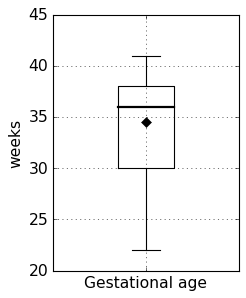

In [14]:
fig, ax = plt.subplots(figsize = (3, 4))
dpi = 300
filetype = 'jpg'
xticklabels = ['Gestational age']

# Define styling for each boxplot component
medianprops = {'color': 'black', 'linewidth': 2}
meanpointprops = {'marker':'D', 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black', 'linestyle': '-'}
whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}
flierprops = {'color': 'black', 'marker': '.'}

plt.boxplot(clin_df['Gestational Age (weeks)'] ,
    widths = 0.3, whis = [0, 100], showfliers = True, showmeans = True, medianprops=medianprops, 
    meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, 
    flierprops = flierprops)

ax.set_ylabel('weeks', size = 14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticklabels(xticklabels)
plt.grid(True)

fig.savefig('%s/%s.%s' % (DIR_WRITE, 'accelero_gest_age', filetype),
    dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

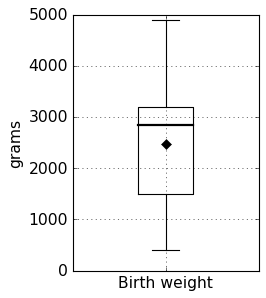

In [15]:
fig, ax = plt.subplots(figsize = (3, 4))
dpi = 300
filetype = 'jpg'
xticklabels = ['Birth weight']

medianprops = {'color': 'black', 'linewidth': 2}
meanpointprops = {'marker':'D', 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black', 'linestyle': '-'}
whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}
flierprops = {'color': 'black', 'marker': '.'}

plt.boxplot(clin_df['Birth Weight'], widths = 0.3, whis = [0, 100], showfliers = True,
             showmeans = True, meanprops = meanpointprops, medianprops=medianprops, boxprops=boxprops, 
        whiskerprops=whiskerprops, capprops=capprops, flierprops = flierprops)

ax.set_xticklabels(xticklabels)
ax.set_ylabel('grams', size = 14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig('%s/%s.%s' % (DIR_WRITE, 'accelero_birth_weight', filetype),
    dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

In [16]:
below_29 = sorted(clin_df[clin_df['Corrected gestational Age (weeks)'] < 29].index)
len(below_29)

15

In [17]:
between_29_32 = sorted(clin_df[(clin_df['Corrected gestational Age (weeks)'] >= 29) & 
                       (clin_df['Corrected gestational Age (weeks)'] < 33)].index)
len(between_29_32)

20

In [18]:
between_33_36 = sorted(clin_df[(clin_df['Corrected gestational Age (weeks)'] >= 33) & 
                       (clin_df['Corrected gestational Age (weeks)'] < 37)].index)
len(between_33_36)

17

In [19]:
between_37_40 = sorted(clin_df[(clin_df['Corrected gestational Age (weeks)'] >= 37) & 
                       (clin_df['Corrected gestational Age (weeks)'] < 41)].index)
len(between_37_40)

45

In [20]:
over_40 = sorted(clin_df[clin_df['Corrected gestational Age (weeks)'] >= 41].index)
len(over_40)

12

#### Clinical problems

In [21]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'clinical_data_accelerometer_final.xlsx'))
clin_df.to_excel(writer, 'cases')
clin_df_stats.to_excel(writer, 'stats')
writer.save()

### 6. Remove the samples with  >46 week corrected gestational age from the ventilator and accelerometer data as well

In [24]:
combined_ventilated_1min = {key: value for key, value in combined_ventilated_1min.items() 
                               if key[1] in patients}

accelero_ventilated = {key: value for key, value in accelero_ventilated.items() 
                               if key[1] in patients}

ventilator_mode = {key: value for key, value in ventilator_mode.items() if key[1] in patients}

In [25]:
len(combined_ventilated_1min), len(accelero_ventilated), len(ventilator_mode)

(109, 109, 109)

In [27]:
len(patients)

109

### 7. Calculate recording durations of the final dataset

In [28]:
recording_durations_final = {}

for recording in combined_ventilated_1min:
    recording_durations_final[recording] = len(combined_ventilated_1min[recording])
    
recording_durations_final = DataFrame(Series(recording_durations_final), columns = ['duration (minutes)'])
recording_durations_final.head()

,,duration (minutes)
default__43.txt,AL000264,82
default__46.txt,AL000267,93
default__53.txt,AL000268,60
default__60.txt,AL000277,60
default__61.txt,AL000279,56


In [29]:
recording_durations_final.describe()

,duration (minutes)
count,109.000000
mean,45.357798
std,26.312060
min,11.000000
25%,20.000000
50%,44.000000
75%,62.000000
max,106.000000


In [30]:
recording_durations_final.sum(), recording_durations_final.sum() / 60, recording_durations_final.sum() / 3600, 

(duration (minutes)    4944
 dtype: int64,
 duration (minutes)    82.4
 dtype: float64,
 duration (minutes)    1.373333
 dtype: float64)

In [31]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'recording_durations_final.xlsx'))
recording_durations_final.to_excel(writer, 'final')
recording_durations_final.describe().to_excel(writer, 'stats')
writer.save()

### 8. Analyse ventilator modes

Only consider those recordings where the ventilation mode did not change during the recording

In [32]:
simv_only = {key[1] for key, value in ventilator_mode.items()
           if 'SIMV' in value['Ventilator_mode'].unique() and len(value['Ventilator_mode'].unique()) == 1}
len(simv_only)

63

In [33]:
sippv_only = {key[1] for key, value in ventilator_mode.items()
           if 'SIPPV' in value['Ventilator_mode'].unique() and len(value['Ventilator_mode'].unique()) == 1}
len(sippv_only)

34

In [34]:
simvpsv_only = {key[1] for key, value in ventilator_mode.items()
           if 'SIMVPSV' in value['Ventilator_mode'].unique() and len(value['Ventilator_mode'].unique()) == 1}
len(simvpsv_only)

4

How many recording has multiple modes

In [35]:
multiple_mode = {key[1] for key, value in ventilator_mode.items()
           if len(value['Ventilator_mode'].unique()) > 1}
len(multiple_mode)

8

How many times was VG on for part or all of the recording

In [36]:
has_VG = set()

for recording in combined_ventilated_1min:
    if 'VG_set_kg_mean' in combined_ventilated_1min[recording].columns:
        has_VG.add(recording)
        # print(recording)

len(has_VG)

97

In [37]:
has_noVG = set()

for recording in combined_ventilated_1min:
    if 'VG_set_kg_mean' not in combined_ventilated_1min[recording].columns:
        has_noVG.add(recording)
    
    elif sum(combined_ventilated_1min[recording]['VG_set_kg_mean'].isnull()):
        has_noVG.add(recording)
    
len(has_noVG)

17

### 9. Generate explanatory graphs for acceleration vectors

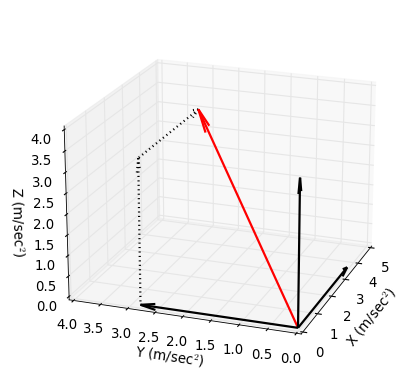

In [38]:
filetype = 'jpg'
dpi  = 200

fig = plt.figure(figsize = [6,6])
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, 3.5, 2.8, 3.5, linewidth = 2, color = 'red', linestyle = '-', arrow_length_ratio = 0.1)
ax.quiver(0, 0, 0, 3.5, 0, 0, linewidth = 2, color = 'black', arrow_length_ratio = 0.1)
ax.quiver(0, 0, 0, 0, 2.8, 0, linewidth = 2, color = 'black', arrow_length_ratio = 0.1)
ax.quiver(0, 0, 0, 0, 0, 3.5, linewidth = 2, color = 'black', arrow_length_ratio = 0.1)

ax.quiver(0, 2.8, 0, 0, 0, 3.5, linewidth = 2, linestyle = 'dotted', color = 'black', arrow_length_ratio = 0.1,)
ax.quiver(0, 2.8, 3.5, 3.5, 0, 0, linewidth = 2, linestyle = 'dotted', color = 'black', arrow_length_ratio = 0.1,)

ax.set_xlim([0, 5]); ax.set_ylim([0,4]); ax.set_zlim([0, 4])
ax.set_xlabel('X (m/sec$^2$)'); ax.set_ylabel('Y (m/sec$^2$)'); ax.set_zlabel('Z (m/sec$^2$)')
ax.view_init(elev=20., azim = 200)

fig.savefig('%s/%s.%s' % (DIR_WRITE, 'accel_explanation', filetype), 
    dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1)

### 10. Generate and export histograms of accelerations using the original accelerometer data (~100 Hz sampling)

### A. Acceleration vectors

In [39]:
def acceleration(rec, direction, bins = 50, xlim = [-3, 3], ylim = [0, 100000], logyscale = False,
               color = 'blue', show = True, save = False, dpi = 200, filetype = 'jpg'):
    
    fig, ax = plt.subplots(figsize = [4, 4])
    
    accelero_ventilated[rec][direction].hist(ax = ax, bins=bins, color = color)
    ax.set_xlabel('m/sec$^2$', size = 12)
    ax.set_ylabel('count', size = 12)
    ax.set_title(direction, size = 14)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    if logyscale:
        ax.set_yscale('log')
    
    name = rec[1] + '_log' if logyscale else rec[1]
    
    if save:       
        fig.savefig('%s/%s_%s_%s.%s' % (DIR_WRITE, 'hist', name, direction, filetype), dpi = dpi, 
           format = filetype, bbox_inches='tight', pad_inches=0.1)
        
    if not show:
        plt.close()

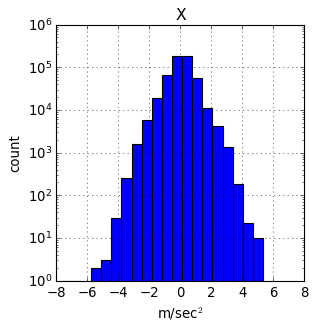

In [40]:
acceleration(('default__393.txt', 'AL000628'), 'X', bins = 20, logyscale = True, xlim = [-8,8],
             ylim = [1, 1000000], save = True)

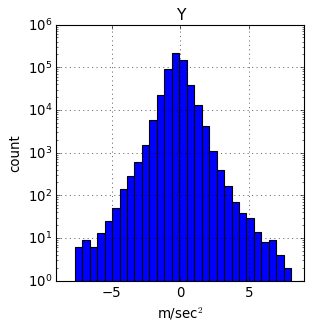

In [41]:
acceleration(('default__393.txt', 'AL000628'), 'Y', bins = 50, logyscale = True, xlim = [-9,9],
             ylim = [1, 1000000], save = True)

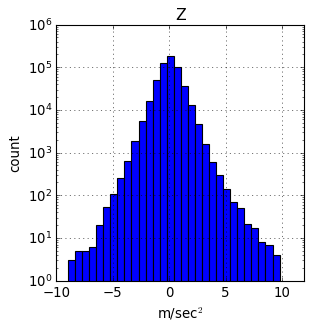

In [42]:
acceleration(('default__393.txt', 'AL000628'), 'Z', bins = 30, logyscale = True, xlim = [-10,12],
             ylim = [1, 1000000], save = True)

#### Absolute value of acceleration vectors

In [43]:
def acceleration_abs(rec, direction, bins = 50, xlim = [0, 8], ylim = [0, 100000], logyscale = False,
               color = 'blue', show = True, save = False, dpi = 200, filetype = 'jpg'):
    
    fig, ax = plt.subplots(figsize = [4, 4])
    
    accelero_ventilated[rec]['%s_abs' % direction].hist(ax = ax, bins=bins, color = color)
    ax.set_xlabel('m/sec$^2$', size = 12)
    ax.set_ylabel('count', size = 12)
    ax.set_title(direction, size = 14)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    if logyscale:
        ax.set_yscale('log')
    
    name = rec[1] + '_log' if logyscale else rec[1]
    
    if save:       
        fig.savefig('%s/%s_%s_%s.%s' % (DIR_WRITE, 'hist_abs', name, direction, filetype), dpi = dpi, 
        format = filetype, bbox_inches='tight', pad_inches=0.1)
        
    if not show:
        plt.close()

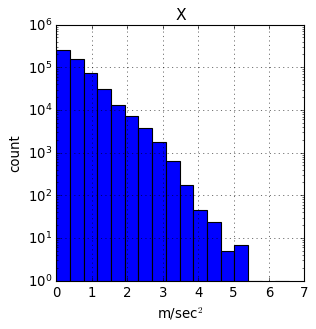

In [44]:
acceleration_abs(('default__393.txt', 'AL000628'), 'X', bins = 20, logyscale = True, xlim = [0,7],
             ylim = [1, 1000000], save = True)

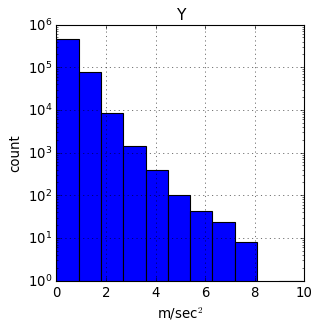

In [45]:
acceleration_abs(('default__393.txt', 'AL000628'), 'Y', bins = 20, logyscale = True, xlim = [0,10],
             ylim = [1, 1000000], save = True)

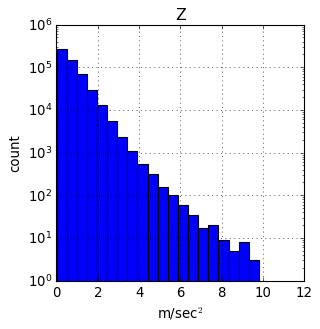

In [46]:
acceleration_abs(('default__393.txt', 'AL000628'), 'Z', bins = 20, logyscale = True, xlim = [0,12],
             ylim = [1, 1000000], save = True)

#### X` (front-back), `Y` (left-right) and `Z` (up-down) acceleration vectors together

In [47]:
def acceleration_XYZ(rec, bins = 50, xlim = [-3, 3], logyscale = False,
               color = 'blue', show = True, save = False, dpi = 200, filetype = 'jpg'):
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = [12, 4], sharex=False, sharey=True)
    
    for par, ax in zip(['X', 'Y', 'Z'], axes.ravel()):
        
        data = accelero_ventilated[rec][par]
        # Remove outlier data outside the X axis scale
        data = data[(data > xlim[0]) & (data < xlim[1])]
        data.hist(ax = ax, bins=bins, color = color)
        ax.set_xlabel('m/sec$^2$', size = 14)
        ax.set_ylabel('count', size = 14)
        ax.set_title(par, size = 16)
        ax.set_xlim(*xlim)
    
        if logyscale:
            ax.set_yscale('log')
    
    name = rec[1] + '_log' if logyscale else rec[1]
    
    if save:
        fig.savefig('%s/%s_%s.%s' % (DIR_WRITE, 'hist_XYZ', name, filetype), dpi = dpi, 
        format = filetype, bbox_inches='tight', pad_inches=0.1)
        
    if not show:
        plt.close()

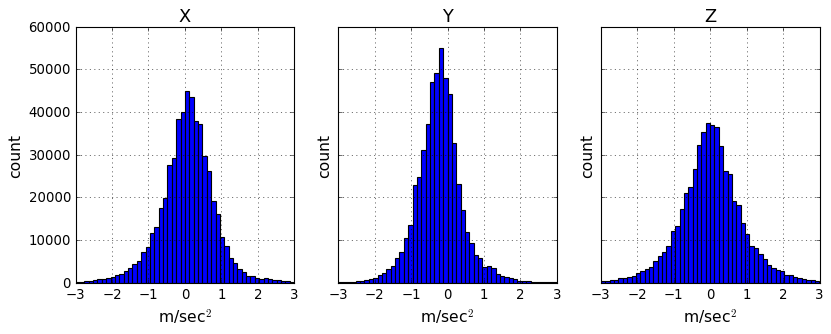

In [48]:
# Example
acceleration_XYZ(('default__393.txt', 'AL000628'), bins = 50, save = True)

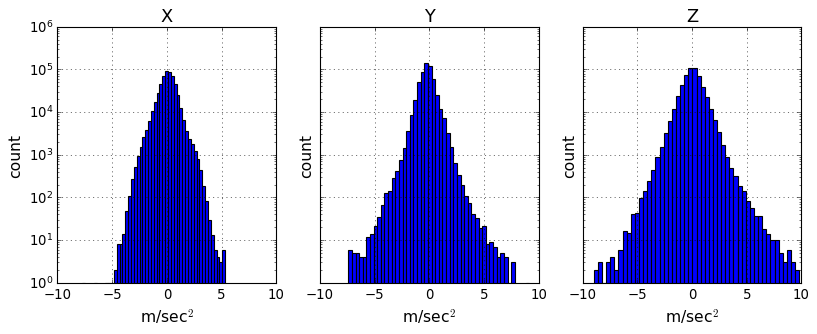

In [49]:
# Example
acceleration_XYZ(('default__393.txt', 'AL000628'), bins = 50, xlim = (-10, 10), logyscale=True, save = True)

In [50]:
def accelerometer_XYZ_all(recs, bins = 50, xlim = [-3, 3], logyscale = False, color = 'blue', 
    name = 'hist_XYZ_all', save = True, show = False, dpi = 200, filetype = 'jpg'):
    '''
    Generates a multiplot graph with the acceleration of all recordings with each recording in a separate
    row. This results in a very large vertical side length of the image
    '''
    fig, axes = plt.subplots(nrows=len(recs), ncols=3, figsize = [12, len(recs) * 4], sharex=False, sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    
    ax_ravelled = axes.ravel()
    i = 0
    for rec in recs:
        for par in ['X', 'Y', 'Z']:
            ax = ax_ravelled[i]
            data = accelero_ventilated[rec][par]
            # Remove outlier data outside the X axis scale
            data = data[(data > xlim[0]) & (data < xlim[1])]
            data.hist(ax = ax , bins=bins, color = color)
            ax.set_xlabel('m/sec$^2$', size = 10)
            ax.set_ylabel('count', size = 10)
            ax.set_title('%s - %s' % (rec[1], par), size = 10)
            ax.set_xlim([*xlim])
            
            if logyscale:
                ax.set_yscale('log')
            
            i+=1
            if i % 10 == 0:
                print(datetime.now(), 'Created %s graphs' %i)
            
    name = name + '_log' if logyscale else name
    
    if save:
        fig.savefig('%s/%s.%s' % (DIR_WRITE, name, filetype), dpi = dpi, 
        format = filetype, bbox_inches='tight', pad_inches=0.1)
        
    if not show:
        plt.close()

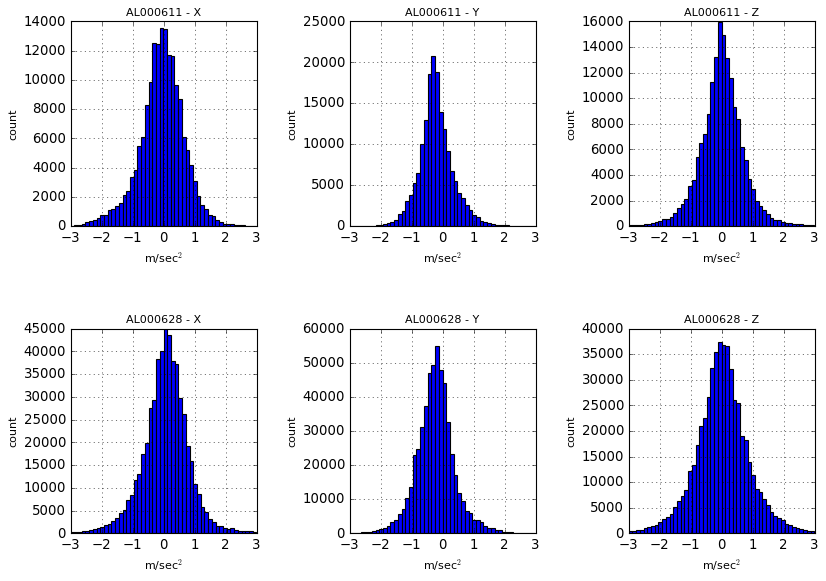

In [51]:
# Example plot
accelerometer_XYZ_all([('default__369.txt', 'AL000611'), ('default__393.txt', 'AL000628')], 
                      show = True, save= False)

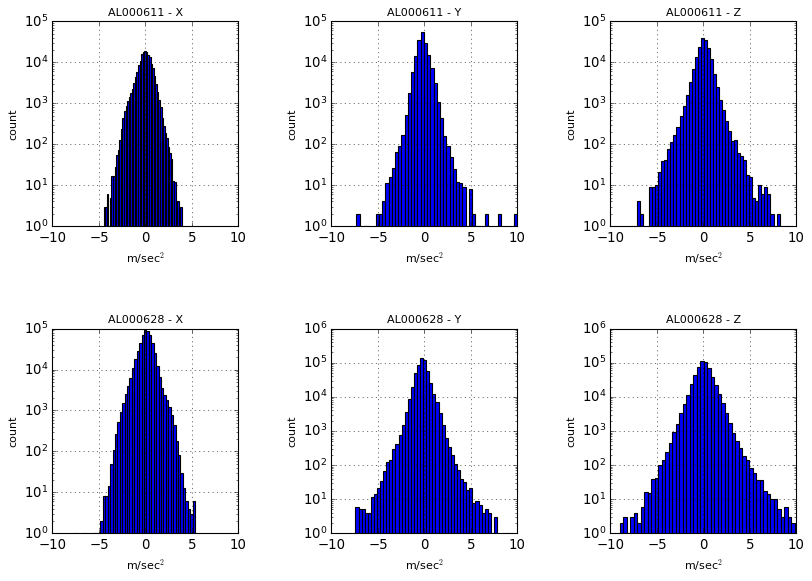

In [52]:
# Example plot
accelerometer_XYZ_all([('default__369.txt', 'AL000611'), ('default__393.txt', 'AL000628')], 
                      xlim = (-10, 10), logyscale=True, show = True, save= False)

In [53]:
def accelerometer_XYZ_all_2(recs, bins = 50, xlim = [-3, 3], logyscale = False, color = 'blue',
    name = 'hist_XYZ_all', save = True, show = False, dpi = 200, filetype = 'jpg'):
    '''
    Generates a multiplot graph with the acceleration of all recordings with each recording in a separate
    row. This results in a very large vertical side length of the image
    '''
    fig, axes = plt.subplots(nrows=len(recs) // 4+1, ncols=12, figsize = [60, 60], sharex=False, sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.6)
    
    ax_ravelled = axes.ravel()
    i = 0
    for rec in recs:
        for par in ['X', 'Y', 'Z']:
            ax = ax_ravelled[i]
            data = accelero_ventilated[rec][par]
            # Remove outlier data outside the X axis scale
            data = data[(data > xlim[0]) & (data < xlim[1])]
            data.hist(ax = ax , bins=bins, color = color)
            ax.set_xlabel('m/sec$^2$', size = 10)
            ax.set_ylabel('count', size = 10)
            ax.set_title('%s - %s' % (rec[1], par), size = 10)
            ax.set_xlim([*xlim])
            
            if logyscale:
                ax.set_yscale('log')
            
            i+=1
            if i % 10 == 0:
                print(datetime.now(), 'Created %s graphs' %i)
            
    name = name + '_log' if logyscale else name
    
    if save:
        fig.savefig('%s/%s.%s' % (DIR_WRITE, name, filetype), dpi = dpi, 
        format = filetype, bbox_inches='tight', pad_inches=0.1)
        
    if not show:
        plt.close()

### B. Length (Euclidean (L2) norm) of the acceleration vectors

In [54]:
def accelerometer_euclidean_norm(rec, bins = 50, xlim = [0, 4], ylim = [0, 40000],
        logyscale = False, color = 'blue', show = True, save = False, dpi = 200, filetype = 'jpg'):
    
    fig, ax = plt.subplots(figsize = [4, 4])
    
    data = accelero_ventilated[rec]['length']
    # Remove outlier data outside the X axis scale
    data = data[(data > xlim[0]) & (data < xlim[1])]
    data.hist(ax = ax, bins=bins, color = color)
    ax.set_xlabel('m/sec$^2$', size = 12)
    ax.set_ylabel('count', size = 12)
    ax.set_title('Euclidean length', size = 14)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    if logyscale:
        ax.set_yscale('log')
    
    name = rec[1] + '_log' if logyscale else rec[1]
    
    if save:       
        fig.savefig('%s/%s_%s.%s' % (DIR_WRITE, 'hist_euclidean', name, filetype), dpi = dpi, 
            format = filetype, bbox_inches='tight', pad_inches=0.1)
        
    if not show:
        plt.close()

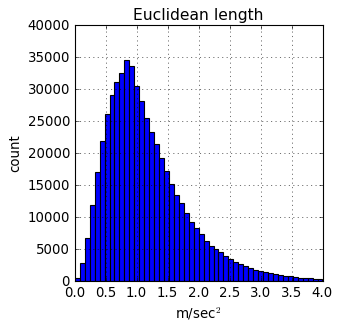

In [55]:
# Example
accelerometer_euclidean_norm(('default__393.txt', 'AL000628'), bins = 50, save = True)

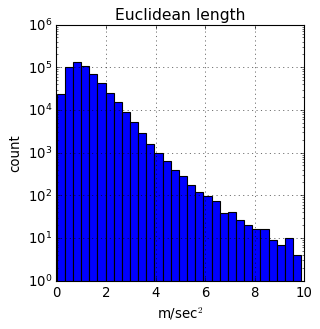

In [56]:
accelerometer_euclidean_norm(('default__393.txt', 'AL000628'), bins = 30,
                             logyscale=True, xlim = (0,10), ylim = (1, 1000000), save = True)

### 11. Analyse distributions of acceleration vector components in the whole recordings

In [57]:
accelero_ventilated[('default__393.txt', 'AL000628')].columns

Index(['X', 'Y', 'Z', 'timedelta', 'ms', 'X_abs', 'Y_abs', 'Z_abs', 'length'], dtype='object')

#### Median of absolute values of acceleration vectors and the euclidean length in each recording overall

In [58]:
to_keep = ['X_abs', 'Y_abs', 'Z_abs', 'length']

accelero_stats_median = {}
for recording in sorted(accelero_ventilated.keys()):
    accelero_stats_median[recording] = accelero_ventilated[recording][to_keep].median()
    
accelero_stats_median = DataFrame(accelero_stats_median).T

accelero_stats_median.head()

,,X_abs,Y_abs,Z_abs,length
default__102.txt,AL000344,0.670,0.392,0.387,1.062237
default__106.txt,AL000348,0.373,0.641,0.138,0.934660
default__109.txt,AL000366,0.555,0.392,0.437,1.108629
default__149.txt,AL000371,0.689,0.201,0.176,0.964443
default__151.txt,AL000375,0.651,0.306,0.303,1.041665


In [59]:
accelero_stats_median_describe = \
    accelero_stats_median.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99])
accelero_stats_median_describe

,X_abs,Y_abs,Z_abs,length
count,109.000000,109.000000,109.000000,109.000000
mean,0.526908,0.319826,0.343917,0.933409
std,0.200167,0.102029,0.114829,0.217484
min,0.076000,0.105000,0.034000,0.180624
1%,0.167360,0.124000,0.080800,0.341060
5%,0.277000,0.156600,0.117800,0.606549
10%,0.316000,0.201000,0.155400,0.660161
25%,0.392000,0.248000,0.301000,0.811533
50%,0.497000,0.306000,0.370000,0.927981
75%,0.632000,0.392000,0.418000,1.057882


In [60]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'median_acceeleration_recordings.xlsx'))
accelero_stats_median.to_excel(writer, 'median_accels')
accelero_stats_median_describe.to_excel(writer, 'median_accel_stats')
writer.save()

#### Distribution of the median absolute acceleration of each recording
Medians are not normally distributed as it can be seen on the graphs; use non-parametric statistics: group medians and IQRs

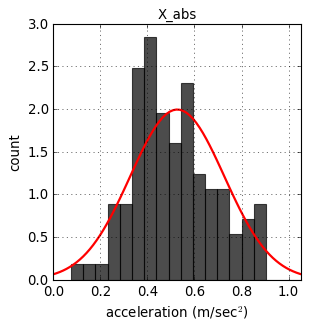

In [61]:
par = 'X_abs'
data = accelero_stats_median[par]

fig, ax = plt.subplots(figsize = [4,4])
ax.hist(data, bins = 25, density = True, color = 'black', alpha = 0.7)    
# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, data.mean(), data.std())
ax.plot(x, p, linewidth=2, color = 'red')
ax.set_xlabel('acceleration (m/sec$^2$)', size = 12)
ax.set_ylabel('count', size = 12)
ax.set_xlim(0, data.mean()*2)
plt.title(par, fontsize = 12)
plt.grid(True)

fig.savefig('%s/%s.%s' % (DIR_WRITE, 'accel_%s_median_hist_with_pdf' % par, 'jpg' ),
    dpi = 200, format = 'jpg', bbox_inches='tight', pad_inches=0.1,);

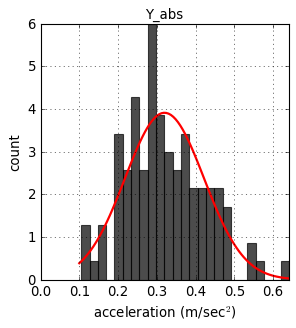

In [62]:
par = 'Y_abs'
data = accelero_stats_median[par]

fig, ax = plt.subplots(figsize = [4,4])
ax.hist(data, bins = 25, density = True, color = 'black', alpha = 0.7)    
# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, data.mean(), data.std())
ax.plot(x, p, linewidth=2, color = 'red')
ax.set_xlabel('acceleration (m/sec$^2$)', size = 12)
ax.set_ylabel('count', size = 12)
ax.set_xlim(0, data.mean()*2)
plt.title(par, fontsize = 12)
plt.grid(True)

fig.savefig('%s/%s.%s' % (DIR_WRITE, 'accel_%s_median_hist_with_pdf' % par, 'jpg' ),
    dpi = 200, format = 'jpg', bbox_inches='tight', pad_inches=0.1,);

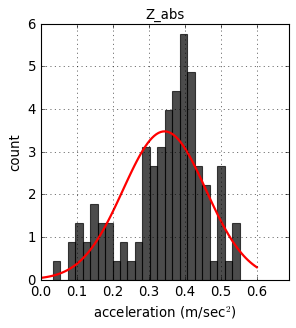

In [63]:
par = 'Z_abs'
data = accelero_stats_median['Z_abs']

fig, ax = plt.subplots(figsize = [4,4])
ax.hist(data, bins = 25, density = True, color = 'black', alpha = 0.7)    
# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, data.mean(), data.std())
ax.plot(x, p, linewidth=2, color = 'red')
ax.set_xlabel('acceleration (m/sec$^2$)', size = 12)
ax.set_ylabel('count', size = 12)
ax.set_xlim(0, data.mean()*2)
plt.title(par, fontsize = 12)
plt.grid(True)

fig.savefig('%s/%s.%s' % (DIR_WRITE, 'accel_Z_abs_median_hist_with_pdf', 'jpg'),
    dpi = 200, format = 'jpg', bbox_inches='tight', pad_inches=0.1,);

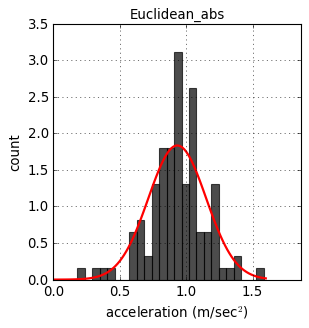

In [64]:
par = 'Euclidean_abs'
data = accelero_stats_median['length']

fig, ax = plt.subplots(figsize = [4,4])
ax.hist(data, bins = 25, density = True, color = 'black', alpha = 0.7)    
# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, data.mean(), data.std())
ax.plot(x, p, linewidth=2, color = 'red')
ax.set_xlabel('acceleration (m/sec$^2$)', size = 12)
ax.set_ylabel('count', size = 12)
ax.set_xlim(0, data.mean()*2)
plt.title('Euclidean_abs', fontsize = 12)
plt.grid(True)

fig.savefig('%s/%s.%s' % (DIR_WRITE, 'accel_euclidean_median_hist_with_pdf', 'jpg'),
    dpi = 200, format = 'jpg', bbox_inches='tight', pad_inches=0.1,);

In [65]:
stats.mannwhitneyu(accelero_stats_median['X_abs'], accelero_stats_median['Y_abs'])

MannwhitneyuResult(statistic=1913.0, pvalue=2.5661457033065035e-18)

In [66]:
stats.mannwhitneyu(accelero_stats_median['X_abs'], accelero_stats_median['Z_abs'])

MannwhitneyuResult(statistic=2536.0, pvalue=1.3278170839035926e-13)

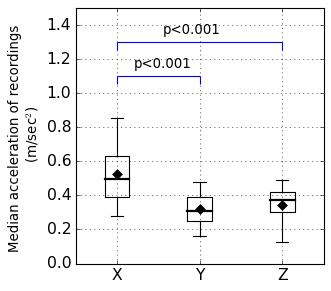

In [67]:
fig, ax = plt.subplots(figsize = (4, 4))
dpi = 300
filetype = 'jpg'
xticklabels = ['X', 'Y', 'Z']

medianprops = {'color': 'black', 'linewidth': 2}
meanpointprops = {'marker':'D', 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black', 'linestyle': '-'}
whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}
flierprops = {'color': 'black', 'marker': '.'}

plt.boxplot([accelero_stats_median['X_abs'], accelero_stats_median['Y_abs'], accelero_stats_median['Z_abs']], 
    widths = 0.3, whis = [5, 95], showfliers = False, showmeans = True, meanprops = meanpointprops, 
        medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, 
            flierprops = flierprops)

ax.hlines([1.1, 1.3], [1, 1], [2, 3])
ax.vlines([1, 2, 1, 3,], [1.1, 1.1, 1.3, 1.3], [1.05, 1.05, 1.25, 1.25])
ax.text(1.2, 1.15, 'p<0.001'); ax.text(1.55, 1.35, 'p<0.001')

ax.set_xticklabels(xticklabels)
ax.set_ylabel('Median acceleration of recordings \n (m/sec$^2$)', size = 12)
ax.set_ylim(0, 1.5)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

fig.savefig('%s/%s.%s' % (DIR_WRITE, 'X_Y_Z_median_boxplot', 'jpg'),
    dpi = 200, format = 'jpg', bbox_inches='tight', pad_inches=0.1,);

### 12. Combine individual DataFrames

In [68]:
# combine DataFrames into one
combined_ventilated_1min_all = pd.concat(combined_ventilated_1min, sort = True)

In [69]:
len(combined_ventilated_1min_all)

4944

In [71]:
# Remove unnecessary columns

columns_to_keep = ['FiO2_set_mean', 'FiO2_set_median', 'FiO2_set_sd', 'Leak_mean', 'Leak_median', 'Leak_sd', 
                   
                   'MAP_mean', 'MAP_sd', 'MV_kg_mean', 'MV_kg_sd', 'MVresp_mean', 'MVresp_sd', 
                   'PIP_mean', 'PIP_sd', 'PIP_set_mean', 'PIP_set_sd',
                   'RR_mean', 'RR_sd', 'RR_set_mean', 'RR_set_sd', 'VG_set_kg_mean', 'VG_set_kg_sd',
                   'VTemand_kg_mean', 'VTemand_kg_sd',
                   'VTemand_resp_kg_mean', 'VTemand_resp_kg_sd', 'VTespon_pat_kg_mean', 'VTespon_pat_kg_sd',
                   'VTimand_kg_mean', 'VTimand_kg_sd', 
                   
                   'Pdiff_VG_abs_mean', 'Pdiff_VG_abs_median', 'Pdiff_VG_abs_sd', 
                   'Pdiff_VG_mean', 'Pdiff_VG_median', 'Pdiff_VG_sd', 
                   'Pdiff_noVG_abs_mean', 'Pdiff_noVG_abs_median', 'Pdiff_noVG_abs_sd', 
                   'Pdiff_noVG_mean', 'Pdiff_noVG_median', 'Pdiff_noVG_sd',
                   
                   'RRdiff_abs_mean', 'RRdiff_abs_median', 'RRdiff_abs_sd', 
                   'RRdiff_mean', 'RRdiff_median', 'RRdiff_sd',
                   
                   'VTdiff_abs_mean', 'VTdiff_abs_median', 'VTdiff_abs_sd', 
                   'VTdiff_mean', 'VTdiff_median', 'VTdiff_sd',
                   
                   'X_abs_median_low_pass', 'X_abs_median_high_pass', 'Y_abs_median_low_pass', 
                   'Y_abs_median_high_pass', 'Z_abs_median_low_pass', 'Z_abs_median_high_pass', 
                   'length_median_low_pass', 'length_median_high_pass']

combined_ventilated_1min_all = combined_ventilated_1min_all[columns_to_keep]

In [72]:
combined_ventilated_1min_all.index.rename(['accel_rec', 'patient', 'datetime'], inplace = True)
combined_ventilated_1min_all.reset_index(inplace = True)
combined_ventilated_1min_all.shape

(4944, 65)

In [73]:
combined_ventilated_1min_all.head()

,accel_rec,patient,datetime,FiO2_set_mean,FiO2_set_median,FiO2_set_sd,Leak_mean,Leak_median,Leak_sd,MAP_mean,MAP_sd,MV_kg_mean,MV_kg_sd,MVresp_mean,MVresp_sd,PIP_mean,PIP_sd,PIP_set_mean,PIP_set_sd,RR_mean,RR_sd,RR_set_mean,RR_set_sd,VG_set_kg_mean,VG_set_kg_sd,VTemand_kg_mean,VTemand_kg_sd,VTemand_resp_kg_mean,VTemand_resp_kg_sd,VTespon_pat_kg_mean,VTespon_pat_kg_sd,VTimand_kg_mean,VTimand_kg_sd,Pdiff_VG_abs_mean,Pdiff_VG_abs_median,Pdiff_VG_abs_sd,Pdiff_VG_mean,Pdiff_VG_median,Pdiff_VG_sd,Pdiff_noVG_abs_mean,Pdiff_noVG_abs_median,Pdiff_noVG_abs_sd,Pdiff_noVG_mean,Pdiff_noVG_median,Pdiff_noVG_sd,RRdiff_abs_mean,RRdiff_abs_median,RRdiff_abs_sd,RRdiff_mean,RRdiff_median,RRdiff_sd,VTdiff_abs_mean,VTdiff_abs_median,VTdiff_abs_sd,VTdiff_mean,VTdiff_median,VTdiff_sd,X_abs_median_low_pass,X_abs_median_high_pass,Y_abs_median_low_pass,Y_abs_median_high_pass,Z_abs_median_low_pass,Z_abs_median_high_pass,length_median_low_pass,length_median_high_pass
0,default__43.txt,AL000264,2018-06-07 17:47:00,30.0,30.0,0.0,0.000000,0.0,0.000000,9.283333,0.577798,0.254690,0.021629,NaN,NaN,18.583333,1.790219,30.0,0.0,63.200000,5.358847,40.0,0.0,4.186047,0.0,3.927907,0.324281,NaN,NaN,NaN,NaN,4.054264,0.183862,11.416667,11.70,1.790219,11.416667,11.70,1.790219,NaN,NaN,NaN,NaN,NaN,NaN,23.200000,26.0,5.358847,23.200000,26.0,5.358847,0.282946,0.139535,0.302115,-0.258140,-0.139535,0.324281,0.553207,0.094761,0.259794,0.053435,0.086447,0.087588,0.615632,0.192302
1,default__43.txt,AL000264,2018-06-07 17:48:00,30.0,30.0,0.0,0.000000,0.0,0.000000,8.583333,1.628217,0.226736,0.005875,NaN,NaN,18.686667,1.512416,30.0,0.0,55.633333,10.819788,40.0,0.0,4.186047,0.0,3.975969,0.222935,NaN,NaN,NaN,NaN,3.910853,0.755850,11.313333,11.80,1.512416,11.313333,11.80,1.512416,NaN,NaN,NaN,NaN,NaN,NaN,18.300000,16.5,4.843410,15.633333,16.0,10.819788,0.227132,0.139535,0.204906,-0.210078,-0.127907,0.222935,0.563226,0.041434,0.235111,0.016961,0.086725,0.024795,0.617408,0.068239
2,default__43.txt,AL000264,2018-06-07 17:49:00,30.0,30.0,0.0,0.000000,0.0,0.000000,8.556667,0.353000,0.229783,0.014178,NaN,NaN,17.083333,1.433848,30.0,0.0,55.966667,2.157318,40.0,0.0,4.186047,0.0,4.062791,0.195352,NaN,NaN,NaN,NaN,4.106202,0.207169,12.916667,13.00,1.433848,12.916667,13.00,1.433848,NaN,NaN,NaN,NaN,NaN,NaN,15.966667,16.0,2.157318,15.966667,16.0,2.157318,0.200775,0.162791,0.110351,-0.123256,-0.139535,0.195352,0.554850,0.036304,0.193166,0.023956,0.085017,0.046428,0.593422,0.079608
3,default__43.txt,AL000264,2018-06-07 17:50:00,30.0,30.0,0.0,0.000000,0.0,0.000000,8.660000,0.469482,0.230829,0.008248,NaN,NaN,17.010000,0.973564,30.0,0.0,55.933333,1.799106,40.0,0.0,4.186047,0.0,4.221705,0.354997,NaN,NaN,NaN,NaN,4.266667,0.389945,12.990000,13.00,0.973564,12.990000,13.00,0.973564,NaN,NaN,NaN,NaN,NaN,NaN,15.933333,16.0,1.799106,15.933333,16.0,1.799106,0.234109,0.139535,0.265785,0.035659,-0.127907,0.354997,0.543375,0.049658,0.197730,0.027949,0.087746,0.046462,0.585095,0.087713
4,default__43.txt,AL000264,2018-06-07 17:51:00,30.0,30.0,0.0,1.266667,0.0,4.884411,8.923333,2.014548,0.161233,0.062271,NaN,NaN,20.653333,4.374198,30.0,0.0,43.766667,12.400454,40.0,0.0,4.186047,0.0,2.862791,1.796965,NaN,NaN,NaN,NaN,2.967442,1.847465,9.346667,10.25,4.374198,9.346667,10.25,4.374198,NaN,NaN,NaN,NaN,NaN,NaN,10.300000,10.0,7.661593,3.766667,5.5,12.400454,1.543411,0.732558,1.605058,-1.323256,-0.523256,1.796965,0.546145,0.046716,0.195541,0.027038,0.090688,0.042500,0.587300,0.081750


### 15. Compare periods with low or high level of vibration

In [75]:
combined_ventilated_1min_all['length_median_high_pass']

0       0.192302
1       0.068239
2       0.079608
3       0.087713
4       0.081750
          ...   
4939    0.877138
4940    0.812820
4941    0.586674
4942    0.267662
4943    0.084913
Name: length_median_high_pass, Length: 4944, dtype: float64

In [76]:
(len(combined_ventilated_1min_all['accel_rec'].unique()), 
len(combined_ventilated_1min_all['patient'].unique()))

(109, 109)

#### A. All minutes (irrespective of ventilation modes and patient characteristics)

##### Using the median and IQR of acceleration

In [264]:
low_1_vibr = {}; high_1_vibr = {}

for patient in combined_ventilated_1min_all['patient'].unique():
    patient_frame = \
        combined_ventilated_1min_all[combined_ventilated_1min_all['patient'] == patient]
    
    # Only consider minutes when there was at least 0.2 m/sec2 vibration
    patient_frame = patient_frame[patient_frame['length_median_high_pass'] >=0.2]
    # Only consider minutes when sustained acceleration was < 0.4 m/sec2
    # patient_frame = patient_frame[patient_frame['length_median_low_pass'] <0.4]
    
    low_1_vibr[patient] = patient_frame.sort_values('length_median_high_pass', ascending = True)[:1]
    high_1_vibr[patient] = patient_frame.sort_values('length_median_high_pass', ascending = True)[-1:]

In [265]:
low_1_vibr['AL000628']

,accel_rec,patient,datetime,FiO2_set_mean,FiO2_set_median,FiO2_set_sd,Leak_mean,Leak_median,Leak_sd,MAP_mean,MAP_sd,MV_kg_mean,MV_kg_sd,MVresp_mean,MVresp_sd,PIP_mean,PIP_sd,PIP_set_mean,PIP_set_sd,RR_mean,RR_sd,RR_set_mean,RR_set_sd,VG_set_kg_mean,VG_set_kg_sd,VTemand_kg_mean,VTemand_kg_sd,VTemand_resp_kg_mean,VTemand_resp_kg_sd,VTespon_pat_kg_mean,VTespon_pat_kg_sd,VTimand_kg_mean,VTimand_kg_sd,Pdiff_VG_abs_mean,Pdiff_VG_abs_median,Pdiff_VG_abs_sd,Pdiff_VG_mean,Pdiff_VG_median,Pdiff_VG_sd,Pdiff_noVG_abs_mean,Pdiff_noVG_abs_median,Pdiff_noVG_abs_sd,Pdiff_noVG_mean,Pdiff_noVG_median,Pdiff_noVG_sd,RRdiff_abs_mean,RRdiff_abs_median,RRdiff_abs_sd,RRdiff_mean,RRdiff_median,RRdiff_sd,VTdiff_abs_mean,VTdiff_abs_median,VTdiff_abs_sd,VTdiff_mean,VTdiff_median,VTdiff_sd,X_abs_median_low_pass,X_abs_median_high_pass,Y_abs_median_low_pass,Y_abs_median_high_pass,Z_abs_median_low_pass,Z_abs_median_high_pass,length_median_low_pass,length_median_high_pass
3323,default__393.txt,AL000628,2019-08-06 21:09:00,21.0,21.0,0.0,0.0,0.0,0.0,10.286667,0.602714,0.29414,0.018461,NaN,NaN,21.226667,1.324031,25.0,0.0,60.166667,3.152266,40.0,0.0,5.052632,0.0,4.803509,0.169243,NaN,NaN,NaN,NaN,4.929825,0.231419,3.773333,3.2,1.324031,3.773333,3.2,1.324031,NaN,NaN,NaN,NaN,NaN,NaN,20.166667,21.0,3.152266,20.166667,21.0,3.152266,0.25614,0.210526,0.158036,-0.249123,-0.210526,0.169243,0.037,0.175604,0.85316,0.11176,0.016264,0.142113,0.858139,0.358823


In [266]:
high_1_vibr['AL000628']

,accel_rec,patient,datetime,FiO2_set_mean,FiO2_set_median,FiO2_set_sd,Leak_mean,Leak_median,Leak_sd,MAP_mean,MAP_sd,MV_kg_mean,MV_kg_sd,MVresp_mean,MVresp_sd,PIP_mean,PIP_sd,PIP_set_mean,PIP_set_sd,RR_mean,RR_sd,RR_set_mean,RR_set_sd,VG_set_kg_mean,VG_set_kg_sd,VTemand_kg_mean,VTemand_kg_sd,VTemand_resp_kg_mean,VTemand_resp_kg_sd,VTespon_pat_kg_mean,VTespon_pat_kg_sd,VTimand_kg_mean,VTimand_kg_sd,Pdiff_VG_abs_mean,Pdiff_VG_abs_median,Pdiff_VG_abs_sd,Pdiff_VG_mean,Pdiff_VG_median,Pdiff_VG_sd,Pdiff_noVG_abs_mean,Pdiff_noVG_abs_median,Pdiff_noVG_abs_sd,Pdiff_noVG_mean,Pdiff_noVG_median,Pdiff_noVG_sd,RRdiff_abs_mean,RRdiff_abs_median,RRdiff_abs_sd,RRdiff_mean,RRdiff_median,RRdiff_sd,VTdiff_abs_mean,VTdiff_abs_median,VTdiff_abs_sd,VTdiff_mean,VTdiff_median,VTdiff_sd,X_abs_median_low_pass,X_abs_median_high_pass,Y_abs_median_low_pass,Y_abs_median_high_pass,Z_abs_median_low_pass,Z_abs_median_high_pass,length_median_low_pass,length_median_high_pass
3312,default__393.txt,AL000628,2019-08-06 20:58:00,21.0,21.0,0.0,0.0,0.0,0.0,11.076667,0.687165,0.315825,0.01602,NaN,NaN,20.45,1.223548,25.0,0.0,66.266667,3.215623,40.0,0.0,4.842105,0.0,4.740351,0.139547,NaN,NaN,NaN,NaN,4.77193,0.141855,4.55,4.65,1.223548,4.55,4.65,1.223548,NaN,NaN,NaN,NaN,NaN,NaN,26.266667,26.0,3.215623,26.266667,26.0,3.215623,0.129825,0.105263,0.11291,-0.101754,-0.105263,0.139547,0.190141,0.474846,0.189221,0.483896,0.093731,0.962349,0.448622,1.480736


In [267]:
low_1_vibr_frme = pd.concat(low_1_vibr).reset_index(level = 1)
low_1_vibr_frme.head()

,level_1,accel_rec,patient,datetime,FiO2_set_mean,FiO2_set_median,FiO2_set_sd,Leak_mean,Leak_median,Leak_sd,MAP_mean,MAP_sd,MV_kg_mean,MV_kg_sd,MVresp_mean,MVresp_sd,PIP_mean,PIP_sd,PIP_set_mean,PIP_set_sd,RR_mean,RR_sd,RR_set_mean,RR_set_sd,VG_set_kg_mean,VG_set_kg_sd,VTemand_kg_mean,VTemand_kg_sd,VTemand_resp_kg_mean,VTemand_resp_kg_sd,VTespon_pat_kg_mean,VTespon_pat_kg_sd,VTimand_kg_mean,VTimand_kg_sd,Pdiff_VG_abs_mean,Pdiff_VG_abs_median,Pdiff_VG_abs_sd,Pdiff_VG_mean,Pdiff_VG_median,Pdiff_VG_sd,Pdiff_noVG_abs_mean,Pdiff_noVG_abs_median,Pdiff_noVG_abs_sd,Pdiff_noVG_mean,Pdiff_noVG_median,Pdiff_noVG_sd,RRdiff_abs_mean,RRdiff_abs_median,RRdiff_abs_sd,RRdiff_mean,RRdiff_median,RRdiff_sd,VTdiff_abs_mean,VTdiff_abs_median,VTdiff_abs_sd,VTdiff_mean,VTdiff_median,VTdiff_sd,X_abs_median_low_pass,X_abs_median_high_pass,Y_abs_median_low_pass,Y_abs_median_high_pass,Z_abs_median_low_pass,Z_abs_median_high_pass,length_median_low_pass,length_median_high_pass
AL000264,12,default__43.txt,AL000264,2018-06-07 17:59:00,30.0,30.0,0.0,0.0,0.0,0.0,7.466667,0.320918,0.218581,0.004487,NaN,NaN,13.803333,1.528913,30.0,0.0,53.566667,0.727932,40.0,0.0,4.186047,0.0,4.116279,0.288532,NaN,NaN,NaN,NaN,4.191473,0.242351,16.196667,16.15,1.528913,16.196667,16.15,1.528913,NaN,NaN,NaN,NaN,NaN,NaN,13.566667,13.0,0.727932,13.566667,13.0,0.727932,0.206202,0.162791,0.210478,-0.069767,-0.069767,0.288532,0.411519,0.112312,0.254189,0.072706,0.099841,0.088364,0.594738,0.213729
AL000267,174,default__46.txt,AL000267,2018-06-08 21:54:00,50.0,50.0,0.0,0.0,0.0,0.0,12.473333,0.565035,0.318720,0.011932,NaN,NaN,28.550000,0.698150,32.0,0.0,45.966667,2.059182,43.0,0.0,7.040000,0.0,6.917333,0.200120,NaN,NaN,NaN,NaN,7.109333,0.161008,3.450000,3.55,0.698150,3.450000,3.55,0.698150,NaN,NaN,NaN,NaN,NaN,NaN,2.966667,3.0,2.059182,2.966667,3.0,2.059182,0.176000,0.160000,0.153524,-0.122667,-0.160000,0.200120,0.690099,0.224680,0.109252,0.113101,0.073474,0.152032,0.722015,0.377492
AL000268,178,default__53.txt,AL000268,2018-06-14 10:57:00,25.0,25.0,0.0,0.0,0.0,0.0,5.543333,0.847993,0.256476,0.028623,54.9,6.304623,9.953333,6.633548,21.0,0.0,49.000000,0.000000,25.0,0.0,4.761905,0.0,6.393651,0.575102,6.228571,0.709001,6.295238,0.273236,6.596825,0.574122,12.040000,14.80,4.503378,11.046667,14.80,6.633548,NaN,NaN,NaN,NaN,NaN,NaN,24.000000,24.0,0.000000,24.000000,24.0,0.000000,1.631746,1.571429,0.575102,1.631746,1.571429,0.575102,0.116029,0.147307,0.170306,0.074120,0.075952,0.129038,0.263430,0.290970
AL000277,294,default__60.txt,AL000277,2018-06-22 13:52:00,21.0,21.0,0.0,0.0,0.0,0.0,11.426667,0.316155,0.259353,0.005608,NaN,NaN,27.513333,1.164336,20.0,0.0,46.733333,1.048261,43.0,0.0,5.921053,0.0,5.569079,0.396919,NaN,NaN,NaN,NaN,5.725877,0.302465,7.513333,7.60,1.164336,-7.513333,-7.60,1.164336,NaN,NaN,NaN,NaN,NaN,NaN,3.733333,4.0,1.048261,3.733333,4.0,1.048261,0.426535,0.312500,0.312244,-0.351974,-0.279605,0.396919,0.309300,0.143114,0.150342,0.060194,0.098361,0.103221,0.362047,0.264256
AL000279,304,default__61.txt,AL000279,2018-06-24 12:05:00,21.0,21.0,0.0,0.0,0.0,0.0,6.750000,1.013614,0.351067,0.043545,NaN,NaN,8.576667,2.240949,20.0,0.0,64.833333,1.464131,45.0,0.0,4.342857,0.0,4.973333,0.908043,NaN,NaN,NaN,NaN,5.142857,0.881302,11.423333,12.20,2.240949,11.423333,12.20,2.240949,NaN,NaN,NaN,NaN,NaN,NaN,19.833333,20.0,1.464131,19.833333,20.0,1.464131,0.908571,0.742857,0.617885,0.630476,0.657143,0.908043,0.227180,0.108694,0.173261,0.063850,0.091008,0.118633,0.326677,0.339964


In [268]:
high_1_vibr_frme = pd.concat(high_1_vibr).reset_index(level = 1)
high_1_vibr_frme.head()

,level_1,accel_rec,patient,datetime,FiO2_set_mean,FiO2_set_median,FiO2_set_sd,Leak_mean,Leak_median,Leak_sd,MAP_mean,MAP_sd,MV_kg_mean,MV_kg_sd,MVresp_mean,MVresp_sd,PIP_mean,PIP_sd,PIP_set_mean,PIP_set_sd,RR_mean,RR_sd,RR_set_mean,RR_set_sd,VG_set_kg_mean,VG_set_kg_sd,VTemand_kg_mean,VTemand_kg_sd,VTemand_resp_kg_mean,VTemand_resp_kg_sd,VTespon_pat_kg_mean,VTespon_pat_kg_sd,VTimand_kg_mean,VTimand_kg_sd,Pdiff_VG_abs_mean,Pdiff_VG_abs_median,Pdiff_VG_abs_sd,Pdiff_VG_mean,Pdiff_VG_median,Pdiff_VG_sd,Pdiff_noVG_abs_mean,Pdiff_noVG_abs_median,Pdiff_noVG_abs_sd,Pdiff_noVG_mean,Pdiff_noVG_median,Pdiff_noVG_sd,RRdiff_abs_mean,RRdiff_abs_median,RRdiff_abs_sd,RRdiff_mean,RRdiff_median,RRdiff_sd,VTdiff_abs_mean,VTdiff_abs_median,VTdiff_abs_sd,VTdiff_mean,VTdiff_median,VTdiff_sd,X_abs_median_low_pass,X_abs_median_high_pass,Y_abs_median_low_pass,Y_abs_median_high_pass,Z_abs_median_low_pass,Z_abs_median_high_pass,length_median_low_pass,length_median_high_pass
AL000264,64,default__43.txt,AL000264,2018-06-07 18:51:00,21.0,21.0,0.0,0.0,0.0,0.0,7.773333,0.360013,0.230682,0.009574,NaN,NaN,14.296667,1.523490,30.0,0.0,57.666667,2.279343,40.0,0.0,4.186047,0.0,4.078295,0.259720,NaN,NaN,NaN,NaN,4.155039,0.216385,15.703333,15.85,1.523490,15.703333,15.85,1.523490,NaN,NaN,NaN,NaN,NaN,NaN,17.666667,18.0,2.279343,17.666667,18.0,2.279343,0.193023,0.116279,0.202293,-0.107752,-0.069767,0.259720,0.125759,0.615485,0.119542,0.315334,0.089838,0.690768,0.223558,1.230256
AL000267,165,default__46.txt,AL000267,2018-06-08 21:45:00,60.0,60.0,0.0,0.0,0.0,0.0,11.916667,0.310820,0.304960,0.005831,NaN,NaN,26.920000,0.588628,32.0,0.0,43.433333,0.678911,43.0,0.0,7.040000,0.0,6.986667,0.121296,NaN,NaN,NaN,NaN,7.024000,0.113915,5.080000,5.30,0.588628,5.080000,5.30,0.588628,NaN,NaN,NaN,NaN,NaN,NaN,0.566667,1.0,0.568321,0.433333,0.0,0.678911,0.106667,0.160000,0.076714,-0.053333,-0.080000,0.121296,0.424505,0.440844,0.238477,0.340780,0.079215,0.760313,0.601216,1.194492
AL000268,179,default__53.txt,AL000268,2018-06-14 10:58:00,25.0,25.0,0.0,0.0,0.0,0.0,6.380000,0.395143,0.246540,0.049654,66.566667,11.23935,12.336667,4.198808,21.0,0.0,49.000000,0.000000,25.0,0.0,4.761905,0.0,5.787302,0.590637,6.263492,0.574531,5.225397,0.350805,6.577778,0.554728,8.663333,10.80,4.198808,8.663333,10.80,4.198808,NaN,NaN,NaN,NaN,NaN,NaN,24.000000,24.0,0.000000,24.000000,24.0,0.000000,1.038095,1.047619,0.567226,1.025397,1.047619,0.590637,0.115688,0.595252,0.147701,0.294257,0.066377,0.577055,0.256586,1.120615
AL000277,243,default__60.txt,AL000277,2018-06-22 13:01:00,21.0,21.0,0.0,0.0,0.0,0.0,10.106667,0.253164,0.268355,0.007798,NaN,NaN,21.530000,1.556333,20.0,0.0,47.100000,1.322224,43.0,0.0,5.921053,0.0,5.736842,0.314757,NaN,NaN,NaN,NaN,5.803728,0.263396,1.563333,1.50,1.521679,-1.530000,-1.50,1.556333,NaN,NaN,NaN,NaN,NaN,NaN,4.100000,4.0,1.322224,4.100000,4.0,1.322224,0.267544,0.131579,0.245210,-0.184211,-0.082237,0.314757,0.330445,0.666745,0.093410,0.421092,0.075620,0.809521,0.358661,1.442892
AL000279,297,default__61.txt,AL000279,2018-06-24 11:58:00,21.0,21.0,0.0,0.0,0.0,0.0,6.143333,0.077385,0.346990,0.039950,NaN,NaN,7.623333,0.567319,20.0,0.0,63.300000,2.070316,45.0,0.0,4.342857,0.0,5.470476,0.820008,NaN,NaN,NaN,NaN,5.586667,0.811138,12.376667,12.40,0.567319,12.376667,12.40,0.567319,NaN,NaN,NaN,NaN,NaN,NaN,18.300000,19.0,2.070316,18.300000,19.0,2.070316,1.154286,1.142857,0.780682,1.127619,1.142857,0.820008,0.173445,0.553694,0.260859,0.406301,0.087067,0.742665,0.467142,1.307565


In [269]:
len(low_1_vibr_frme)

109

In [270]:
def two_paired_test(arr_1, arr_2, par):
    return {     'parameter': par,
                 'low_mean':  round(arr_1[par].mean(), 2),
                 'low_median': round(arr_1[par].median(), 2),
                 'low_sd':    round(arr_1[par].std(), 2),
                 'low_min': round(arr_1[par].min(), 2),
                 'low_max': round(arr_1[par].max(), 2),
                 'high_mean': round(arr_2[par].mean(), 2),
                 'high_median': round(arr_2[par].median(), 2),
                 'high_sd':   round(arr_2[par].std(), 2),
                 'high_min': round(arr_2[par].min(), 2),
                 'high_max': round(arr_2[par].max(), 2),
                 'statistic': round(stats.ttest_rel(arr_1[par], arr_2[par])[0], 2),
                 'p-value':   stats.ttest_rel(arr_1[par], arr_2[par])[1],}

In [271]:
columns_to_analyse_1 = ['length_median_high_pass']

comparison_stats_1 = []
for column in columns_to_analyse_1:
    comparison_stats_1.append(two_paired_test(low_1_vibr_frme, high_1_vibr_frme, column))

comparison_stats_frme_1 = DataFrame(comparison_stats_1, index= columns_to_analyse_1)
comparison_stats_frme_1

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
length_median_high_pass,length_median_high_pass,0.34,0.33,0.1,0.2,0.6,1.09,1.09,0.19,0.59,1.68,-40.26,7.316717e-67


In [272]:
columns_to_analyse_2 = [ 'FiO2_set_mean',   'Leak_median', 
                        'MV_kg_mean', 'PIP_mean', 'VTemand_kg_mean', ]

comparison_stats_2 = []

for column in columns_to_analyse_2:
    comparison_stats_2.append(two_paired_test(low_1_vibr_frme, high_1_vibr_frme, column))

comparison_stats_frme_2 = DataFrame(comparison_stats_2, index= columns_to_analyse_2)
comparison_stats_frme_2

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
FiO2_set_mean,FiO2_set_mean,36.56,25.00,21.87,21.00,100.00,36.97,30.00,21.56,21.00,100.00,-0.63,0.528870
Leak_median,Leak_median,6.41,0.00,17.69,0.00,82.00,7.67,0.00,19.37,0.00,90.00,-1.08,0.282465
MV_kg_mean,MV_kg_mean,0.28,0.26,0.11,0.00,0.68,0.29,0.27,0.11,0.00,0.69,-1.47,0.145337
PIP_mean,PIP_mean,17.77,17.93,6.67,4.88,37.89,18.02,19.05,6.71,5.48,39.96,-0.88,0.378294
VTemand_kg_mean,VTemand_kg_mean,5.23,4.93,1.76,0.03,11.26,5.28,4.87,1.86,0.08,12.76,-0.59,0.554198


In [273]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'vibr_filt_stats_all_recs.xlsx'))
comparison_stats_frme_1.to_excel(writer, 'accels')
comparison_stats_frme_2.to_excel(writer, 'vent_pars')
writer.save()

#### B. VG ventilation

During these minutes the set tidal volume `VG_set_kg_mean` has a specific value different from np.nan

In [202]:
(len(combined_ventilated_1min_all), 
 sum(combined_ventilated_1min_all['VG_set_kg_mean'].notnull()),
 sum(combined_ventilated_1min_all['VG_set_kg_mean'].isnull()), 
 sum(combined_ventilated_1min_all['VG_set_kg_mean'] == 0))

(4944, 4434, 510, 0)

In [203]:
VG = combined_ventilated_1min_all[combined_ventilated_1min_all['VG_set_kg_mean'].notnull()].copy()
len(VG)

4434

In [204]:
len(VG['accel_rec'].unique()), len(VG['patient'].unique())

(97, 97)

In [205]:
low_1_VG = {}; high_1_VG = {}

for patient in VG['patient'].unique():
    patient_frame_VG = VG[VG['patient'] == patient]
    
    # Only consider minutes when there was at least 0.2 m/sec2 vibration
    patient_frame_VG = patient_frame_VG[patient_frame_VG['length_median_high_pass'] >=0.2]
    # Only consider minutes when sustained acceleration was < 0.4 m/sec2
    patient_frame_VG = patient_frame_VG[patient_frame_VG['length_median_low_pass'] < 0.4]
    
    low_1_VG[patient] = patient_frame_VG.sort_values('length_median_high_pass', ascending = True)[:1]
    high_1_VG[patient] = patient_frame_VG.sort_values('length_median_high_pass', ascending = True)[-1:]

low_1_frme_VG = pd.concat(low_1_VG)
high_1_frme_VG = pd.concat(high_1_VG)

In [206]:
columns_to_analyse_1_VG = ['length_median_high_pass',]

comparison_stats_1_VG = []

for column in columns_to_analyse_1_VG:
    comparison_stats_1_VG.append(two_paired_test(low_1_frme_VG, high_1_frme_VG, column))

comparison_stats_frme_1_VG = DataFrame(comparison_stats_1_VG, index = columns_to_analyse_1_VG)
comparison_stats_frme_1_VG

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
length_median_high_pass,length_median_high_pass,0.49,0.51,0.19,0.2,0.89,0.96,0.95,0.22,0.35,1.44,-13.51,8.416039e-21


In [207]:
columns_to_analyse_2_VG = ['PIP_mean', 'VTemand_kg_mean', 'VTdiff_abs_median',  'Pdiff_VG_abs_median', ]

comparison_stats_2_VG = []
for column in columns_to_analyse_2_VG:
    comparison_stats_2_VG.append(two_paired_test(low_1_frme_VG, high_1_frme_VG, column))

comparison_stats_frme_2_VG = DataFrame(comparison_stats_2_VG, index = columns_to_analyse_2_VG)
comparison_stats_frme_2_VG

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
PIP_mean,PIP_mean,18.02,17.66,7.82,5.35,37.89,18.12,19.36,7.27,5.01,39.96,-0.26,0.797790
VTemand_kg_mean,VTemand_kg_mean,5.03,4.95,1.41,2.65,11.26,5.10,4.94,1.46,2.62,11.30,-1.08,0.282643
VTdiff_abs_median,VTdiff_abs_median,0.78,0.49,0.90,0.03,4.40,0.80,0.52,0.94,0.03,4.84,-0.32,0.752969
Pdiff_VG_abs_median,Pdiff_VG_abs_median,12.68,12.90,7.49,0.20,31.20,12.38,12.73,7.76,0.10,29.90,0.62,0.540372


In [208]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'vibr_filt_stats_VG.xlsx'))
comparison_stats_frme_1_VG.to_excel(writer, 'accels')
comparison_stats_frme_2_VG.to_excel(writer, 'vent_pars')
writer.save()

#### C. Minutes with pressure limited (non-VG) ventilation

In [209]:
Plim = combined_ventilated_1min_all[combined_ventilated_1min_all['VG_set_kg_mean'].isnull()].copy()
len(Plim)

510

In [210]:
Plim.shape

(510, 65)

In [211]:
len(Plim['accel_rec'].unique()), len(Plim['patient'].unique())

(17, 17)

In [213]:
low_1_Plim= {}; high_1_Plim = {}

for patient in Plim['patient'].unique():
    patient_frame_Plim = Plim[Plim['patient'] == patient]
    
    # Only consider minutes when there was at least 0.2 m/sec2 vibration
    patient_frame_Plim = patient_frame_Plim[patient_frame_Plim['length_median_high_pass'] >=0.2]
    # Only consider minutes when sustained acceleration was < 0.4 m/sec2
    patient_frame_Plim = patient_frame_Plim[patient_frame_Plim['length_median_low_pass'] < 0.4]
    
    low_1_Plim[patient] = patient_frame_Plim.sort_values('length_median_high_pass', ascending = True)[:1]
    high_1_Plim[patient] = patient_frame_Plim.sort_values('length_median_low_pass', ascending = True)[-1:]

low_1_frme_Plim = pd.concat(low_1_Plim)
high_1_frme_Plim = pd.concat(high_1_Plim)

In [214]:
columns_to_analyse_1_Plim = ['length_median_high_pass']

comparison_stats_1_Plim = []

for column in columns_to_analyse_1_Plim:
    comparison_stats_1_Plim.append(two_paired_test(low_1_frme_Plim, high_1_frme_Plim, column))

comparison_stats_frme_1_Plim = DataFrame(comparison_stats_1_Plim, index = columns_to_analyse_1_Plim)
comparison_stats_frme_1_Plim

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
length_median_high_pass,length_median_high_pass,0.46,0.32,0.27,0.26,1.07,0.59,0.57,0.28,0.26,1.07,-1.88,0.089656


In [215]:
columns_to_analyse_2_Plim = ['PIP_mean', 'VTemand_kg_mean', 'Pdiff_noVG_abs_median',]

comparison_stats_2_Plim = []

for column in columns_to_analyse_2_Plim:
    comparison_stats_2_Plim.append(two_paired_test(low_1_frme_Plim, high_1_frme_Plim, column))

comparison_stats_frme_2_Plim = DataFrame(comparison_stats_2_Plim, index = columns_to_analyse_2_Plim)
comparison_stats_frme_2_Plim

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
PIP_mean,PIP_mean,18.40,18.11,3.28,15.27,26.81,18.42,18.17,3.27,15.27,26.82,-1.94,0.080978
VTemand_kg_mean,VTemand_kg_mean,5.51,6.30,2.98,0.13,10.70,5.48,6.30,3.03,0.13,10.70,0.27,0.791750
Pdiff_noVG_abs_median,Pdiff_noVG_abs_median,0.59,0.30,0.65,0.20,1.75,0.69,0.50,0.61,0.20,1.75,NaN,NaN


In [216]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'vibr_filt_stats_Plim.xlsx'))
comparison_stats_frme_1_Plim.to_excel(writer, 'accels')
comparison_stats_frme_2_Plim.to_excel(writer, 'vent_pars')
writer.save()

#### D. Minutes with SIPPV ventilation

In [217]:
len(sippv_only)

34

In [218]:
sippv = combined_ventilated_1min_all[combined_ventilated_1min_all['patient'].isin(sippv_only)].copy()
len(sippv)

1545

In [219]:
len(sippv['accel_rec'].unique()), len(sippv['patient'].unique())

(34, 34)

In [220]:
low_1_sippv= {}; high_1_sippv = {}

for patient in sippv['patient'].unique():
    patient_frame_sippv = sippv[sippv['patient'] == patient]
    
    # Only consider minutes when there was at least 0.2 m/sec2 vibration
    patient_frame_sippv = patient_frame_sippv[patient_frame_sippv['length_median_high_pass'] >=0.2]
    # Only consider minutes when sustained acceleration was < 0.4 m/sec2
    patient_frame_sippv = patient_frame_sippv[patient_frame_sippv['length_median_low_pass'] < 0.4]
    
    low_1_sippv[patient] = patient_frame_sippv.sort_values('length_median_high_pass', ascending = True)[:1]
    high_1_sippv[patient] = patient_frame_sippv.sort_values('length_median_high_pass', ascending = True)[-1:]

low_1_frme_sippv = pd.concat(low_1_sippv)
high_1_frme_sippv = pd.concat(high_1_sippv)

In [221]:
columns_to_analyse_1_sippv = ['length_median_high_pass',]

comparison_stats_1_sippv = []

for column in columns_to_analyse_1_sippv:
    comparison_stats_1_sippv.append(two_paired_test(low_1_frme_sippv, high_1_frme_sippv, column))

comparison_stats_frme_1_sippv = DataFrame(comparison_stats_1_sippv, index = columns_to_analyse_1_sippv)
comparison_stats_frme_1_sippv

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
length_median_high_pass,length_median_high_pass,0.44,0.43,0.18,0.2,0.89,0.99,0.95,0.2,0.61,1.44,-12.73,3.649982e-12


In [222]:
columns_to_analyse_2_sippv = ['RR_mean',  'RRdiff_abs_median', ]

comparison_stats_2_sippv = []

for column in columns_to_analyse_2_sippv:
    comparison_stats_2_sippv.append(two_paired_test(low_1_frme_sippv, high_1_frme_sippv, column))

comparison_stats_frme_2_sippv = DataFrame(comparison_stats_2_sippv, index = columns_to_analyse_2_sippv)
comparison_stats_frme_2_sippv

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
RR_mean,RR_mean,58.57,57.8,14.63,34.33,94.57,60.07,60.67,13.81,34.57,89.03,-1.28,0.211514
RRdiff_abs_median,RRdiff_abs_median,13.94,10.0,14.36,0.00,55.00,15.32,16.00,13.91,0.00,50.00,-1.13,0.270369


In [223]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'vibr_filt_stats_sippv.xlsx'))
comparison_stats_frme_1_sippv.to_excel(writer, 'accels')
comparison_stats_frme_2_sippv.to_excel(writer, 'vent_pars')
writer.save()

#### E. Minutes with SIMV ventilation

In [224]:
len(simv_only)

63

In [225]:
simv = combined_ventilated_1min_all[combined_ventilated_1min_all['patient'].isin(simv_only)].copy()
len(simv)

2611

In [226]:
len(simv['accel_rec'].unique()), len(simv['patient'].unique())

(63, 63)

In [231]:
low_1_simv= {}; high_1_simv = {}

for patient in simv['patient'].unique():
    patient_frame_simv = simv[simv['patient'] == patient]
    
    # Only consider minutes when there was at least 0.2 m/sec2 vibration
    patient_frame_simv = patient_frame_simv[patient_frame_simv['length_median_high_pass'] >=0.2]
    # Only consider minutes when sustained acceleration was < 0.4 m/sec2
    patient_frame_simv = patient_frame_simv[patient_frame_simv['length_median_low_pass'] < 0.4]
    
    low_1_simv[patient] = patient_frame_simv.sort_values('length_median_high_pass', ascending = True)[:1]
    high_1_simv[patient] = patient_frame_simv.sort_values('length_median_high_pass', ascending = True)[-1:]

low_1_frme_simv = pd.concat(low_1_simv)
high_1_frme_simv = pd.concat(high_1_simv)

In [232]:
columns_to_analyse_1_simv = ['length_median_high_pass', ]

comparison_stats_1_simv = []

for column in columns_to_analyse_1_simv:
    comparison_stats_1_simv.append(two_paired_test(low_1_frme_simv, high_1_frme_simv, column))

comparison_stats_frme_1_simv = DataFrame(comparison_stats_1_simv, index = columns_to_analyse_1_simv)
comparison_stats_frme_1_simv

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
length_median_high_pass,length_median_high_pass,0.5,0.5,0.22,0.2,1.07,0.94,0.98,0.24,0.35,1.33,-8.54,1.006199e-10


In [233]:
columns_to_analyse_2_simv = ['VTemand_kg_mean', 'VTemand_resp_kg_mean', 'VTespon_pat_kg_mean', ]

comparison_stats_2_simv = []

for column in columns_to_analyse_2_simv:
    comparison_stats_2_simv.append(two_paired_test(low_1_frme_simv, high_1_frme_simv, column))

comparison_stats_frme_2_simv = DataFrame(comparison_stats_2_simv, index = columns_to_analyse_2_simv)
comparison_stats_frme_2_simv

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
VTemand_kg_mean,VTemand_kg_mean,4.98,4.41,2.09,0.13,11.26,5.00,4.71,2.16,0.13,11.30,-0.22,0.825214
VTemand_resp_kg_mean,VTemand_resp_kg_mean,5.40,5.05,1.94,0.13,11.26,5.49,5.05,2.10,0.13,12.27,-0.90,0.371950
VTespon_pat_kg_mean,VTespon_pat_kg_mean,2.52,1.74,2.49,0.00,8.16,2.44,1.46,2.52,0.00,8.15,0.57,0.570040


In [234]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'vibr_stats_filt_simv.xlsx'))
comparison_stats_frme_1_simv.to_excel(writer, 'accels')
comparison_stats_frme_2_simv.to_excel(writer, 'vent_pars')
writer.save()

#### E. Effect of gestation

<29 weeks corrected gestational age, all ventilated data

In [235]:
vent_data_below_29 = \
    combined_ventilated_1min_all[combined_ventilated_1min_all['patient'].isin(below_29)].copy()
len(vent_data_below_29)

852

In [236]:
### All received VG ventilation

(len(vent_data_below_29), 
 sum(vent_data_below_29['VG_set_kg_mean'].notnull()),
 sum(vent_data_below_29['VG_set_kg_mean'].isnull()), 
 sum(vent_data_below_29['VG_set_kg_mean'] == 0))

(852, 852, 0, 0)

In [237]:
vent_data_below_29['VTdiff'] = vent_data_below_29['VTemand_kg_mean'] - vent_data_below_29['VG_set_kg_mean']
vent_data_below_29['VTdiff_abs'] = np.abs(vent_data_below_29['VTemand_kg_mean'] - vent_data_below_29['VG_set_kg_mean'])
vent_data_below_29['Pdiff_VG'] = vent_data_below_29['PIP_set_mean'] - vent_data_below_29['PIP_mean']

In [238]:
vent_data_below_29.shape

(852, 68)

In [239]:
len(vent_data_below_29['accel_rec'].unique()), len(vent_data_below_29['patient'].unique())

(15, 15)

In [240]:
low_1_vent_data_below_29= {}; high_1_vent_data_below_29 = {}

for patient in vent_data_below_29['patient'].unique():
    patient_frame_vent_data_below_29 = vent_data_below_29[vent_data_below_29['patient'] == patient]
    
    # Only consider minutes when there was at least 0.2 m/sec2 vibration
    patient_frame_vent_data_below_29 = \
        patient_frame_vent_data_below_29[patient_frame_vent_data_below_29['length_median_high_pass'] >=0.2]
    # Only consider minutes when sustained acceleration was < 0.4 m/sec2
    patient_frame_vent_data_below_29 = \
        patient_frame_vent_data_below_29[patient_frame_vent_data_below_29['length_median_low_pass'] < 0.4]
    
    low_1_vent_data_below_29[patient] = patient_frame_vent_data_below_29.sort_values('length_median_high_pass', 
                                                                                ascending = True)[:1]
    high_1_vent_data_below_29[patient] = patient_frame_vent_data_below_29.sort_values('length_median_high_pass', 
                                                                                ascending = True)[-1:]

low_1_frme_vent_data_below_29 = pd.concat(low_1_vent_data_below_29)
high_1_frme_vent_data_below_29 = pd.concat(high_1_vent_data_below_29)

In [241]:
columns_to_analyse_1_vent_data_below_29 = ['length_median_high_pass', ]

comparison_stats_1_vent_data_below_29 = []

for column in columns_to_analyse_1_vent_data_below_29:
    comparison_stats_1_vent_data_below_29.append(two_paired_test(low_1_frme_vent_data_below_29, 
                                                                 high_1_frme_vent_data_below_29, column))

comparison_stats_frme_1_vent_data_below_29 = DataFrame(comparison_stats_1_vent_data_below_29, 
                                                       index = columns_to_analyse_1_vent_data_below_29)
comparison_stats_frme_1_vent_data_below_29

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
length_median_high_pass,length_median_high_pass,0.5,0.51,0.16,0.27,0.77,0.94,0.93,0.14,0.74,1.23,-6.27,0.000146


In [242]:
columns_to_analyse_2_vent_data_below_29 = ['FiO2_set_mean',  'Leak_median', 
                                           'MV_kg_mean', 'PIP_mean',  'VTemand_kg_mean',]

comparison_stats_2_vent_data_below_29 = []

for column in columns_to_analyse_2_vent_data_below_29:
    comparison_stats_2_vent_data_below_29.append(two_paired_test(low_1_frme_vent_data_below_29, 
                                                                 high_1_frme_vent_data_below_29, column))

comparison_stats_frme_2_vent_data_below_29 = DataFrame(comparison_stats_2_vent_data_below_29, 
                                                       index = columns_to_analyse_2_vent_data_below_29)
comparison_stats_frme_2_vent_data_below_29

,parameter,low_mean,low_median,low_sd,low_min,low_max,high_mean,high_median,high_sd,high_min,high_max,statistic,p-value
FiO2_set_mean,FiO2_set_mean,30.40,25.00,13.63,21.00,60.00,34.80,30.00,15.77,21.00,60.00,-1.14,0.285671
Leak_median,Leak_median,6.55,0.00,17.34,0.00,55.00,0.00,0.00,0.00,0.00,0.00,1.19,0.262818
MV_kg_mean,MV_kg_mean,0.31,0.31,0.06,0.22,0.40,0.32,0.32,0.06,0.22,0.41,-0.23,0.820686
PIP_mean,PIP_mean,20.05,19.26,6.84,8.35,30.24,18.60,19.88,7.39,5.01,28.35,1.40,0.193730
VTemand_kg_mean,VTemand_kg_mean,5.78,5.61,0.86,4.53,7.24,5.89,6.18,0.93,4.22,7.23,-0.89,0.397501


In [243]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'vibr_stats_filt_below_29weeks_recs.xlsx'))
comparison_stats_frme_1_vent_data_below_29.to_excel(writer, 'accels')
comparison_stats_frme_2_vent_data_below_29.to_excel(writer, 'vent_pars')
writer.save()

### 17. Compare periods with low and high sustained acceleration 

In [244]:
len(combined_ventilated_1min_all)

4944

In [245]:
combined_ventilated_1min_all.head()

,accel_rec,patient,datetime,FiO2_set_mean,FiO2_set_median,FiO2_set_sd,Leak_mean,Leak_median,Leak_sd,MAP_mean,MAP_sd,MV_kg_mean,MV_kg_sd,MVresp_mean,MVresp_sd,PIP_mean,PIP_sd,PIP_set_mean,PIP_set_sd,RR_mean,RR_sd,RR_set_mean,RR_set_sd,VG_set_kg_mean,VG_set_kg_sd,VTemand_kg_mean,VTemand_kg_sd,VTemand_resp_kg_mean,VTemand_resp_kg_sd,VTespon_pat_kg_mean,VTespon_pat_kg_sd,VTimand_kg_mean,VTimand_kg_sd,Pdiff_VG_abs_mean,Pdiff_VG_abs_median,Pdiff_VG_abs_sd,Pdiff_VG_mean,Pdiff_VG_median,Pdiff_VG_sd,Pdiff_noVG_abs_mean,Pdiff_noVG_abs_median,Pdiff_noVG_abs_sd,Pdiff_noVG_mean,Pdiff_noVG_median,Pdiff_noVG_sd,RRdiff_abs_mean,RRdiff_abs_median,RRdiff_abs_sd,RRdiff_mean,RRdiff_median,RRdiff_sd,VTdiff_abs_mean,VTdiff_abs_median,VTdiff_abs_sd,VTdiff_mean,VTdiff_median,VTdiff_sd,X_abs_median_low_pass,X_abs_median_high_pass,Y_abs_median_low_pass,Y_abs_median_high_pass,Z_abs_median_low_pass,Z_abs_median_high_pass,length_median_low_pass,length_median_high_pass
0,default__43.txt,AL000264,2018-06-07 17:47:00,30.0,30.0,0.0,0.000000,0.0,0.000000,9.283333,0.577798,0.254690,0.021629,NaN,NaN,18.583333,1.790219,30.0,0.0,63.200000,5.358847,40.0,0.0,4.186047,0.0,3.927907,0.324281,NaN,NaN,NaN,NaN,4.054264,0.183862,11.416667,11.70,1.790219,11.416667,11.70,1.790219,NaN,NaN,NaN,NaN,NaN,NaN,23.200000,26.0,5.358847,23.200000,26.0,5.358847,0.282946,0.139535,0.302115,-0.258140,-0.139535,0.324281,0.553207,0.094761,0.259794,0.053435,0.086447,0.087588,0.615632,0.192302
1,default__43.txt,AL000264,2018-06-07 17:48:00,30.0,30.0,0.0,0.000000,0.0,0.000000,8.583333,1.628217,0.226736,0.005875,NaN,NaN,18.686667,1.512416,30.0,0.0,55.633333,10.819788,40.0,0.0,4.186047,0.0,3.975969,0.222935,NaN,NaN,NaN,NaN,3.910853,0.755850,11.313333,11.80,1.512416,11.313333,11.80,1.512416,NaN,NaN,NaN,NaN,NaN,NaN,18.300000,16.5,4.843410,15.633333,16.0,10.819788,0.227132,0.139535,0.204906,-0.210078,-0.127907,0.222935,0.563226,0.041434,0.235111,0.016961,0.086725,0.024795,0.617408,0.068239
2,default__43.txt,AL000264,2018-06-07 17:49:00,30.0,30.0,0.0,0.000000,0.0,0.000000,8.556667,0.353000,0.229783,0.014178,NaN,NaN,17.083333,1.433848,30.0,0.0,55.966667,2.157318,40.0,0.0,4.186047,0.0,4.062791,0.195352,NaN,NaN,NaN,NaN,4.106202,0.207169,12.916667,13.00,1.433848,12.916667,13.00,1.433848,NaN,NaN,NaN,NaN,NaN,NaN,15.966667,16.0,2.157318,15.966667,16.0,2.157318,0.200775,0.162791,0.110351,-0.123256,-0.139535,0.195352,0.554850,0.036304,0.193166,0.023956,0.085017,0.046428,0.593422,0.079608
3,default__43.txt,AL000264,2018-06-07 17:50:00,30.0,30.0,0.0,0.000000,0.0,0.000000,8.660000,0.469482,0.230829,0.008248,NaN,NaN,17.010000,0.973564,30.0,0.0,55.933333,1.799106,40.0,0.0,4.186047,0.0,4.221705,0.354997,NaN,NaN,NaN,NaN,4.266667,0.389945,12.990000,13.00,0.973564,12.990000,13.00,0.973564,NaN,NaN,NaN,NaN,NaN,NaN,15.933333,16.0,1.799106,15.933333,16.0,1.799106,0.234109,0.139535,0.265785,0.035659,-0.127907,0.354997,0.543375,0.049658,0.197730,0.027949,0.087746,0.046462,0.585095,0.087713
4,default__43.txt,AL000264,2018-06-07 17:51:00,30.0,30.0,0.0,1.266667,0.0,4.884411,8.923333,2.014548,0.161233,0.062271,NaN,NaN,20.653333,4.374198,30.0,0.0,43.766667,12.400454,40.0,0.0,4.186047,0.0,2.862791,1.796965,NaN,NaN,NaN,NaN,2.967442,1.847465,9.346667,10.25,4.374198,9.346667,10.25,4.374198,NaN,NaN,NaN,NaN,NaN,NaN,10.300000,10.0,7.661593,3.766667,5.5,12.400454,1.543411,0.732558,1.605058,-1.323256,-0.523256,1.796965,0.546145,0.046716,0.195541,0.027038,0.090688,0.042500,0.587300,0.081750


In [252]:
low_1_accel = {}; high_1_accel = {}

for patient in combined_ventilated_1min_all['patient'].unique():
    patient_frame = \
        combined_ventilated_1min_all[combined_ventilated_1min_all['patient'] == patient]
    
    # Only consider minutes when there was at least 0.2 m/sec2 sustained_acceleration
    patient_frame = patient_frame[patient_frame['length_median_low_pass'] >=0.2]
    
    low_1_accel[patient] = patient_frame.sort_values('length_median_low_pass', ascending = True)[:1]
    high_1_accel[patient] = patient_frame.sort_values('length_median_low_pass', ascending = True)[-1:]

In [253]:
len(low_1_accel), len(high_1_accel)

(109, 109)

In [254]:
low_1_accel_frame = pd.concat(low_1_accel).reset_index(level = 1)
low_1_accel_frame.head()

,level_1,accel_rec,patient,datetime,FiO2_set_mean,FiO2_set_median,FiO2_set_sd,Leak_mean,Leak_median,Leak_sd,MAP_mean,MAP_sd,MV_kg_mean,MV_kg_sd,MVresp_mean,MVresp_sd,PIP_mean,PIP_sd,PIP_set_mean,PIP_set_sd,RR_mean,RR_sd,RR_set_mean,RR_set_sd,VG_set_kg_mean,VG_set_kg_sd,VTemand_kg_mean,VTemand_kg_sd,VTemand_resp_kg_mean,VTemand_resp_kg_sd,VTespon_pat_kg_mean,VTespon_pat_kg_sd,VTimand_kg_mean,VTimand_kg_sd,Pdiff_VG_abs_mean,Pdiff_VG_abs_median,Pdiff_VG_abs_sd,Pdiff_VG_mean,Pdiff_VG_median,Pdiff_VG_sd,Pdiff_noVG_abs_mean,Pdiff_noVG_abs_median,Pdiff_noVG_abs_sd,Pdiff_noVG_mean,Pdiff_noVG_median,Pdiff_noVG_sd,RRdiff_abs_mean,RRdiff_abs_median,RRdiff_abs_sd,RRdiff_mean,RRdiff_median,RRdiff_sd,VTdiff_abs_mean,VTdiff_abs_median,VTdiff_abs_sd,VTdiff_mean,VTdiff_median,VTdiff_sd,X_abs_median_low_pass,X_abs_median_high_pass,Y_abs_median_low_pass,Y_abs_median_high_pass,Z_abs_median_low_pass,Z_abs_median_high_pass,length_median_low_pass,length_median_high_pass
AL000264,64,default__43.txt,AL000264,2018-06-07 18:51:00,21.0,21.0,0.0,0.000000,0.0,0.000000,7.773333,0.360013,0.230682,0.009574,NaN,NaN,14.296667,1.523490,30.0,0.0,57.666667,2.279343,40.0,0.0,4.186047,0.0,4.078295,0.259720,NaN,NaN,NaN,NaN,4.155039,0.216385,15.703333,15.85,1.523490,15.703333,15.85,1.523490,NaN,NaN,NaN,NaN,NaN,NaN,17.666667,18.0,2.279343,17.666667,18.0,2.279343,0.193023,0.116279,0.202293,-0.107752,-0.069767,0.259720,0.125759,0.615485,0.119542,0.315334,0.089838,0.690768,0.223558,1.230256
AL000267,111,default__46.txt,AL000267,2018-06-08 20:51:00,60.0,60.0,0.0,0.000000,0.0,0.000000,12.776667,0.147819,0.308000,0.007040,NaN,NaN,30.240000,1.289106,32.0,0.0,43.600000,1.003442,43.0,0.0,7.040000,0.0,6.944000,0.360475,NaN,NaN,NaN,NaN,7.205333,0.289539,1.760000,1.70,1.289106,1.760000,1.70,1.289106,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,0.0,1.003442,0.600000,0.0,1.003442,0.256000,0.160000,0.267731,-0.096000,-0.160000,0.360475,0.100577,0.166256,0.133315,0.105989,0.110205,0.291340,0.203575,0.430023
AL000268,214,default__53.txt,AL000268,2018-06-14 11:33:00,25.0,25.0,0.0,10.233333,9.0,10.663128,5.706667,0.523208,0.188921,0.015433,80.833333,2.335385,8.290000,2.555501,21.0,0.0,49.000000,0.000000,25.0,0.0,4.761905,0.0,5.222222,0.349331,5.292063,0.473677,4.539683,1.242592,5.803175,0.282891,12.710000,13.65,2.555501,12.710000,13.65,2.555501,NaN,NaN,NaN,NaN,NaN,NaN,24.000000,24.0,0.000000,24.000000,24.0,0.000000,0.498413,0.571429,0.290258,0.460317,0.571429,0.349331,0.162971,0.429499,0.034164,0.285655,0.094702,0.352514,0.201101,0.783542
AL000277,274,default__60.txt,AL000277,2018-06-22 13:32:00,21.0,21.0,0.0,0.000000,0.0,0.000000,7.850000,0.196082,0.258180,0.003963,NaN,NaN,16.496667,0.681015,20.0,0.0,44.366667,1.066200,43.0,0.0,5.921053,0.0,5.819079,0.253090,NaN,NaN,NaN,NaN,5.868421,0.235407,3.503333,3.50,0.681015,3.503333,3.50,0.681015,NaN,NaN,NaN,NaN,NaN,NaN,1.433333,1.5,0.971431,1.366667,1.5,1.066200,0.180921,0.115132,0.202362,-0.101974,-0.049342,0.253090,0.165830,0.501993,0.039113,0.295370,0.096716,0.437739,0.218184,0.880073
AL000279,305,default__61.txt,AL000279,2018-06-24 12:06:00,21.0,21.0,0.0,0.000000,0.0,0.000000,6.973333,1.233423,0.292248,0.029558,NaN,NaN,9.173333,3.006537,20.0,0.0,62.933333,1.142693,45.0,0.0,4.342857,0.0,4.649524,0.576428,NaN,NaN,NaN,NaN,4.746667,0.623614,10.826667,12.10,3.006537,10.826667,12.10,3.006537,NaN,NaN,NaN,NaN,NaN,NaN,17.933333,18.0,1.142693,17.933333,18.0,1.142693,0.554286,0.457143,0.334260,0.306667,0.314286,0.576428,0.231003,0.046378,0.024107,0.026732,0.093670,0.056322,0.250460,0.094816


In [255]:
high_1_accel_frame = pd.concat(high_1_accel).reset_index(level = 1)
high_1_accel_frame.head()

,level_1,accel_rec,patient,datetime,FiO2_set_mean,FiO2_set_median,FiO2_set_sd,Leak_mean,Leak_median,Leak_sd,MAP_mean,MAP_sd,MV_kg_mean,MV_kg_sd,MVresp_mean,MVresp_sd,PIP_mean,PIP_sd,PIP_set_mean,PIP_set_sd,RR_mean,RR_sd,RR_set_mean,RR_set_sd,VG_set_kg_mean,VG_set_kg_sd,VTemand_kg_mean,VTemand_kg_sd,VTemand_resp_kg_mean,VTemand_resp_kg_sd,VTespon_pat_kg_mean,VTespon_pat_kg_sd,VTimand_kg_mean,VTimand_kg_sd,Pdiff_VG_abs_mean,Pdiff_VG_abs_median,Pdiff_VG_abs_sd,Pdiff_VG_mean,Pdiff_VG_median,Pdiff_VG_sd,Pdiff_noVG_abs_mean,Pdiff_noVG_abs_median,Pdiff_noVG_abs_sd,Pdiff_noVG_mean,Pdiff_noVG_median,Pdiff_noVG_sd,RRdiff_abs_mean,RRdiff_abs_median,RRdiff_abs_sd,RRdiff_mean,RRdiff_median,RRdiff_sd,VTdiff_abs_mean,VTdiff_abs_median,VTdiff_abs_sd,VTdiff_mean,VTdiff_median,VTdiff_sd,X_abs_median_low_pass,X_abs_median_high_pass,Y_abs_median_low_pass,Y_abs_median_high_pass,Z_abs_median_low_pass,Z_abs_median_high_pass,length_median_low_pass,length_median_high_pass
AL000264,60,default__43.txt,AL000264,2018-06-07 18:47:00,21.0,21.0,0.0,0.0,0.0,0.0,7.216667,0.128877,0.231899,0.005950,NaN,NaN,13.176667,0.728571,30.0,0.0,56.266667,1.638614,40.0,0.0,4.186047,0.0,4.140310,0.171492,NaN,NaN,NaN,NaN,4.212403,0.211627,16.823333,16.80,0.728571,16.823333,16.80,0.728571,NaN,NaN,NaN,NaN,NaN,NaN,16.266667,16.0,1.638614,16.266667,16.0,1.638614,0.143411,0.139535,0.101477,-0.045736,-0.069767,0.171492,1.167462,0.643694,0.149299,0.288544,0.093641,0.590669,1.230005,1.178205
AL000267,150,default__46.txt,AL000267,2018-06-08 21:30:00,60.0,60.0,0.0,0.0,0.0,0.0,11.750000,0.147975,0.299307,0.005429,NaN,NaN,26.880000,0.343812,32.0,0.0,43.600000,0.723974,43.0,0.0,7.040000,0.0,6.832000,0.206488,NaN,NaN,NaN,NaN,6.965333,0.081187,5.120000,5.15,0.343812,5.120000,5.15,0.343812,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,1.0,0.660895,0.600000,1.0,0.723974,0.208000,0.160000,0.206488,-0.208000,-0.160000,0.206488,1.132339,0.342742,0.288405,0.169638,0.080625,0.437710,1.176341,0.734583
AL000268,183,default__53.txt,AL000268,2018-06-14 11:02:00,25.0,25.0,0.0,0.0,0.0,0.0,5.426667,0.258555,0.275619,0.016779,52.266667,5.526945,8.020000,2.375362,21.0,0.0,49.000000,0.000000,25.0,0.0,4.761905,0.0,5.822222,1.108609,5.333333,0.575247,6.047619,0.636055,6.073016,1.010287,12.980000,13.55,2.375362,12.980000,13.55,2.375362,NaN,NaN,NaN,NaN,NaN,NaN,24.000000,24.0,0.000000,24.000000,24.0,0.000000,1.111111,0.666667,1.055896,1.060317,0.666667,1.108609,0.392136,0.282230,0.292531,0.178302,0.078028,0.436575,0.710694,0.696158
AL000277,260,default__60.txt,AL000277,2018-06-22 13:18:00,21.0,21.0,0.0,0.0,0.0,0.0,8.463333,0.653628,0.271338,0.008945,NaN,NaN,18.460000,2.535894,20.0,0.0,45.333333,1.935750,43.0,0.0,5.921053,0.0,6.013158,0.308628,NaN,NaN,NaN,NaN,6.072368,0.260106,2.600000,2.40,1.375149,1.540000,2.40,2.535894,NaN,NaN,NaN,NaN,NaN,NaN,2.400000,2.0,1.849511,2.333333,2.0,1.935750,0.265351,0.230263,0.176602,0.092105,0.180921,0.308628,0.718174,0.252284,0.385708,0.158308,0.101518,0.337775,0.913748,0.585168
AL000279,349,default__61.txt,AL000279,2018-06-24 12:50:00,41.0,41.0,0.0,0.0,0.0,0.0,5.866667,0.172873,0.438971,0.042119,NaN,NaN,7.253333,0.813139,20.0,0.0,74.266667,0.944433,45.0,0.0,4.342857,0.0,5.843810,1.421415,NaN,NaN,NaN,NaN,5.937143,1.422240,12.746667,13.00,0.813139,12.746667,13.00,0.813139,NaN,NaN,NaN,NaN,NaN,NaN,29.266667,29.0,0.944433,29.266667,29.0,0.944433,1.516190,0.771429,1.404586,1.500952,0.771429,1.421415,0.485687,0.342175,0.643571,0.180593,0.053371,0.306939,0.825115,0.671563


In [256]:
len(high_1_accel_frame)

109

#### Consider only those pairs when the high acceleration is >0.6 m/sec2 and the low accel is <0.6 m/sec2

In [257]:
(high_1_accel_frame['length_median_low_pass'] - low_1_accel_frame['length_median_low_pass'])

AL000264    1.006447
AL000267    0.972766
AL000268    0.509593
AL000277    0.695564
AL000279    0.574655
AL000281    0.474466
AL000284    0.477402
AL000286    0.819929
AL000289    0.310533
AL000291    0.792083
AL000301    1.176649
AL000307    1.170935
AL000310    1.488486
AL000344    1.203522
AL000348    0.612755
AL000366    1.124966
AL000371    0.608385
AL000375    0.890408
AL000376    0.884520
AL000378    0.868514
AL000381    0.733456
AL000390    1.335663
AL000400    0.344659
AL000402    0.891440
AL000405    1.381985
AL000406    0.500712
AL000410    0.846734
AL000432    0.921333
AL000435    1.114374
AL000437    0.669320
AL000443    1.074813
AL000445    1.064658
AL000455    0.471211
AL000457    0.874417
AL000458    0.643919
AL000461    1.011224
AL000465    0.851600
AL000468    1.541984
AL000469    1.052650
AL000470    0.437485
AL000475    0.232640
AL000479    0.475199
AL000480    0.457125
AL000485    0.851082
AL000488    0.742150
AL000491    1.071218
AL000501    0.350362
AL000503    1

In [258]:
def two_paired_test(arr_1, arr_2, par):
    return {     'parameter': par,
                 'low_mean':  round(arr_1[par].mean(), 2),
                 'low_sd':    round(arr_1[par].std(), 2),
                 'high_mean': round(arr_2[par].mean(), 2),  
                 'high_sd':   round(arr_2[par].std(), 2),
                 'statistic': round(stats.ttest_rel(arr_1[par], arr_2[par])[0], 2),
                 'p-value':   stats.ttest_rel(arr_1[par], arr_2[par])[1],}

In [259]:
columns_to_analyse_1 = ['length_median_low_pass', ]

comparison_stats_1 = []
for column in columns_to_analyse_1:
    comparison_stats_1.append(two_paired_test(low_1_accel_frame, high_1_accel_frame, column))

comparison_stats_frme_1 = DataFrame(comparison_stats_1, index= columns_to_analyse_1)
comparison_stats_frme_1

,parameter,low_mean,low_sd,high_mean,high_sd,statistic,p-value
length_median_low_pass,length_median_low_pass,0.33,0.16,1.18,0.33,-27.11,5.376950e-50


In [260]:
columns_to_analyse_2 = ['FiO2_set_median', 'Leak_median', 'MV_kg_mean','PIP_mean',  'VTemand_kg_mean',  ]

comparison_stats_2 = []
for column in columns_to_analyse_2:
    comparison_stats_2.append(two_paired_test(low_1_accel_frame, high_1_accel_frame, column))

comparison_stats_frme_2 = DataFrame(comparison_stats_2, index= columns_to_analyse_2)
comparison_stats_frme_2

,parameter,low_mean,low_sd,high_mean,high_sd,statistic,p-value
FiO2_set_median,FiO2_set_median,36.48,21.36,37.03,22.04,-0.89,0.375116
Leak_median,Leak_median,7.84,19.15,6.92,17.67,0.85,0.398603
MV_kg_mean,MV_kg_mean,0.29,0.11,0.29,0.11,-0.12,0.903305
PIP_mean,PIP_mean,18.04,7.06,18.17,6.70,-0.39,0.700515
VTemand_kg_mean,VTemand_kg_mean,5.28,1.88,5.25,1.82,0.37,0.714574


In [261]:
writer = pd.ExcelWriter('%s/%s' % (DIR_WRITE, 'sustained_acccel_filt_stats_all_recs.xlsx'))
comparison_stats_frme_1.to_excel(writer, 'accels')
comparison_stats_frme_2.to_excel(writer, 'vent_pars')
writer.save()

### 18. Export the filtered DataFrames

In [274]:
with open('%s/%s.pickle' % (DATA_DUMP, 'combined_ventilated_1min_all'), 'wb') as handle:
    pickle.dump(combined_ventilated_1min_all, handle, protocol=pickle.HIGHEST_PROTOCOL) 

with open('%s/%s.pickle' % (DATA_DUMP, 'low_1_vibr_frame'), 'wb') as handle:
    pickle.dump(low_1_vibr_frme, handle, protocol=pickle.HIGHEST_PROTOCOL) 

with open('%s/%s.pickle' % (DATA_DUMP, 'high_1_vibr_frame'), 'wb') as handle:
    pickle.dump(high_1_vibr_frme, handle, protocol=pickle.HIGHEST_PROTOCOL) 
                            
with open('%s/%s.pickle' % (DATA_DUMP, 'low_1_accel_frame'), 'wb') as handle:
    pickle.dump(low_1_accel_frame, handle, protocol=pickle.HIGHEST_PROTOCOL) 

with open('%s/%s.pickle' % (DATA_DUMP, 'high_1_accel_frame'), 'wb') as handle:
    pickle.dump(high_1_accel_frame, handle, protocol=pickle.HIGHEST_PROTOCOL)    